# Hybrid ML + Rule-Based Trading Strategy

This notebook combines machine learning market regime classification with rule-based trading strategies.

## Strategy Overview:
1. **Market Regime Classification**: ML models classify market conditions (Bull/Bear/Sideways)
2. **Regime-Specific Strategies**: Different rule-based strategies for each market regime
3. **Multi-Timeframe Testing**: Backtest across 1min, 15min, 30min, 1day datasets
4. **Pipeline Architecture**: Modular design for easy strategy switching

## Key Components:
- **Regime Classifiers**: Random Forest, XGBoost, SVM models
- **Bull Market Strategy**: Aggressive trend-following with momentum
- **Bear Market Strategy**: Conservative short-term mean reversion
- **Sideways Market Strategy**: Range-bound trading with tight stops
- **Risk Management**: Adaptive position sizing and stop-loss based on regime

In [27]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os

# ML imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import joblib

# Technical analysis
import sys
sys.path.append('../features')
from trend_indicator_pipeline_pkg import TrendIndicatorPipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("Imports complete")

Imports complete


## 1. Data Loading and Preparation

In [28]:
def load_and_split_dataset(train_ratio=0.3):
    """
    Load 1D momentum regime dataset and split chronologically for ML training
    
    Args:
        train_ratio: Fraction of data to use for training (default 0.3 = 30%)
    
    Returns:
        train_df: First 30% of data for ML training
        test_df: Last 70% of data for backtesting
        full_df: Complete dataset for reference
    """
    data_dir = '../data'
    filename = 'BTCUSD_2023_1min_enhanced_regimes_1D_momentum.csv'
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"Error: {filepath} not found. Available files:")
        for f in os.listdir(data_dir):
            if f.endswith('.csv'):
                print(f"  {f}")
        return None, None, None
    
    print("Loading 1D momentum regime dataset for ML training...")
    df = pd.read_csv(filepath)
    
    # Handle timestamp column and ensure proper sorting
    timestamp_col = 'timestamp' if 'timestamp' in df.columns else 'Timestamp'
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df = df.set_index(timestamp_col).sort_index()  # Ensure chronological order
    
    # Clean up unnecessary columns
    cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=cols_to_drop)
    
    # Verify regime column exists
    if 'regime' not in df.columns:
        raise ValueError("No 'regime' column found - required for ML training ground truth")
    
    print(f"Dataset loaded: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print(f"Timespan: {(df.index.max() - df.index.min()).days} days")
    
    # Chronological split for ML training
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx].copy()  # First 30% for training
    test_df = df.iloc[split_idx:].copy()   # Last 70% for backtesting
    
    print(f"\nTrain/Test Split (Chronological):")
    print(f"Training set: {train_df.shape} ({train_ratio*100:.0f}%)")
    print(f"  Date range: {train_df.index.min()} to {train_df.index.max()}")
    print(f"  Duration: {(train_df.index.max() - train_df.index.min()).days} days")
    
    print(f"Testing set: {test_df.shape} ({(1-train_ratio)*100:.0f}%)")
    print(f"  Date range: {test_df.index.min()} to {test_df.index.max()}")
    print(f"  Duration: {(test_df.index.max() - test_df.index.min()).days} days")
    
    # Analyze regime distribution in both sets
    print(f"\nRegime Distribution in Training Set:")
    train_regime_counts = train_df['regime'].value_counts().sort_index()
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    for regime, count in train_regime_counts.items():
        pct = count / len(train_df) * 100
        print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")
    
    print(f"\nRegime Distribution in Testing Set:")
    test_regime_counts = test_df['regime'].value_counts().sort_index()
    for regime, count in test_regime_counts.items():
        pct = count / len(test_df) * 100
        print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")
    
    # Verify no data leakage
    assert train_df.index.max() < test_df.index.min(), "Data leakage detected: train and test periods overlap!"
    
    return train_df, test_df, df

# Load and split the dataset
train_df, test_df, full_df = load_and_split_dataset(train_ratio=0.3)

# Display sample of training data
if train_df is not None:
    print(f"\nTraining Data Sample:")
    print(train_df.head())
else:
    print("Failed to load dataset!")

Loading 1D momentum regime dataset for ML training...
Dataset loaded: (434438, 33)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00
Timespan: 324 days

Train/Test Split (Chronological):
Training set: (130331, 33) (30%)
  Date range: 2023-02-10 00:00:00 to 2023-05-15 21:34:00
  Duration: 94 days
Testing set: (304107, 33) (70%)
  Date range: 2023-05-15 21:35:00 to 2023-12-31 14:27:00
  Duration: 229 days

Regime Distribution in Training Set:
  Bear (0): 32,416 (24.9%)
  Sideways (1): 88,035 (67.5%)
  Bull (2): 9,880 (7.6%)

Regime Distribution in Testing Set:
  Bear (0): 42,189 (13.9%)
  Sideways (1): 208,450 (68.5%)
  Bull (2): 53,468 (17.6%)

Training Data Sample:
                        Open     High      Low    Close    Volume  \
timestamp                                                           
2023-02-10 00:00:00  21759.9  21766.7  21750.3  21764.5  0.002615   
2023-02-10 00:01:00  21764.9  21766.2  21751.4  21752.8  0.001451   
2023-02-10 00:02:00  21752.7  21752.7  21724.

## 2. Feature Engineering for ML Training

Now we'll engineer comprehensive features for training ML classifiers to predict market regimes.

In [29]:
def engineer_ml_features(df, lookback_windows=[5, 10, 20, 50]):
    """
    Engineer comprehensive features for ML regime classification
    
    Args:
        df: DataFrame with OHLCV and technical indicators
        lookback_windows: Different window periods for feature engineering
        
    Returns:
        DataFrame with engineered features ready for ML training
    """
    df = df.copy()
    
    print("Engineering features for ML training...")
    
    # 1. Price-based features
    print("  - Price-based features")
    for window in lookback_windows:
        # Returns and volatility
        df[f'return_{window}d'] = df['Close'].pct_change(window)
        df[f'volatility_{window}d'] = df['Close'].pct_change().rolling(window).std()
        
        # Trend strength
        df[f'trend_strength_{window}d'] = (df['Close'] - df['Close'].shift(window)) / df['Close'].shift(window)
        
        # Price position relative to moving averages
        if f'sma_{window}d' in df.columns:
            df[f'price_vs_sma_{window}d'] = (df['Close'] - df[f'sma_{window}d']) / df[f'sma_{window}d']
        if f'ema_{window}d' in df.columns:
            df[f'price_vs_ema_{window}d'] = (df['Close'] - df[f'ema_{window}d']) / df[f'ema_{window}d']
    
    # 2. Technical indicator features
    print("  - Technical indicator features")
    
    # RSI features
    if 'rsi_14d' in df.columns:
        df['rsi_normalized'] = (df['rsi_14d'] - 50) / 50  # Normalize around neutral
        df['rsi_momentum'] = df['rsi_14d'].diff()
        df['rsi_oversold'] = (df['rsi_14d'] < 30).astype(int)
        df['rsi_overbought'] = (df['rsi_14d'] > 70).astype(int)
    
    # MACD features
    if 'macd_hist_12_26' in df.columns:
        df['macd_trend'] = np.where(df['macd_hist_12_26'] > 0, 1, -1)
        df['macd_momentum'] = df['macd_hist_12_26'].diff()
        df['macd_strength'] = abs(df['macd_hist_12_26'])
        
        if 'macd_12_26' in df.columns and 'macd_sig_12_26' in df.columns:
            df['macd_signal_cross'] = (df['macd_12_26'] > df['macd_sig_12_26']).astype(int)
    
    # Bollinger Bands features
    if all(col in df.columns for col in ['bb_upper_20d', 'bb_mid_20d', 'bb_lower_20d']):
        df['bb_position'] = (df['Close'] - df['bb_lower_20d']) / (df['bb_upper_20d'] - df['bb_lower_20d'])
        df['bb_squeeze'] = (df['bb_upper_20d'] - df['bb_lower_20d']) / df['bb_mid_20d']
        df['bb_breakout_upper'] = (df['Close'] > df['bb_upper_20d']).astype(int)
        df['bb_breakout_lower'] = (df['Close'] < df['bb_lower_20d']).astype(int)
    
    # 3. Moving average relationships
    print("  - Moving average relationships")
    ma_pairs = [(7, 20), (7, 30), (20, 30)]
    for fast, slow in ma_pairs:
        if f'ema_{fast}d' in df.columns and f'ema_{slow}d' in df.columns:
            df[f'ema_{fast}_{slow}_cross'] = (df[f'ema_{fast}d'] > df[f'ema_{slow}d']).astype(int)
            df[f'ema_{fast}_{slow}_spread'] = (df[f'ema_{fast}d'] - df[f'ema_{slow}d']) / df[f'ema_{slow}d']
        
        if f'sma_{fast}d' in df.columns and f'sma_{slow}d' in df.columns:
            df[f'sma_{fast}_{slow}_cross'] = (df[f'sma_{fast}d'] > df[f'sma_{slow}d']).astype(int)
            df[f'sma_{fast}_{slow}_spread'] = (df[f'sma_{fast}d'] - df[f'sma_{slow}d']) / df[f'sma_{slow}d']
    
    # 4. Volume features
    print("  - Volume features")
    if 'Volume' in df.columns:
        df['volume_sma_20'] = df['Volume'].rolling(20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_sma_20']
        df['volume_momentum'] = df['Volume'].pct_change(5)
        df['high_volume'] = (df['volume_ratio'] > 2).astype(int)
    
    # 5. Fractal dimension features
    print("  - Fractal dimension features")
    if 'fd_14d' in df.columns:
        df['fd_trend'] = df['fd_14d'].diff()
        df['fd_normalized'] = (df['fd_14d'] - df['fd_14d'].rolling(50).mean()) / df['fd_14d'].rolling(50).std()
        
        if 'fd_7d' in df.columns and 'fd_30d' in df.columns:
            df['fd_short_long'] = df['fd_7d'] - df['fd_30d']
            df['fd_complexity'] = (df['fd_14d'] > 1.5).astype(int)  # High complexity indicator
    
    # 6. Momentum and trend features
    print("  - Momentum and trend features")
    
    # Price momentum
    for period in [3, 5, 10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(period)
        df[f'momentum_{period}d_rank'] = df[f'momentum_{period}d'].rolling(50).rank(pct=True)
    
    # Trend consistency
    df['trend_consistency_5d'] = df['Close'].rolling(5).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    df['trend_consistency_10d'] = df['Close'].rolling(10).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    
    # 7. Volatility regime features
    print("  - Volatility regime features")
    
    # Rolling volatility
    for window in [10, 20, 30]:
        rolling_vol = df['Close'].pct_change().rolling(window).std()
        df[f'volatility_{window}d'] = rolling_vol
        df[f'volatility_{window}d_rank'] = rolling_vol.rolling(100).rank(pct=True)
        df[f'high_volatility_{window}d'] = (rolling_vol > rolling_vol.rolling(100).quantile(0.8)).astype(int)
    
    # 8. Multi-timeframe features (if available)
    print("  - Multi-timeframe features")
    timeframe_cols = [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    for col in timeframe_cols:
        if col in df.columns:
            # Count regime consistency across timeframes
            df[f'{col}_consistency'] = (df[col] == df['regime']).astype(int)
    
    # 9. Lag features for temporal patterns
    print("  - Lag features")
    key_features = ['rsi_14d', 'macd_hist_12_26', 'bb_position']
    for feature in key_features:
        if feature in df.columns:
            for lag in [1, 2, 3, 5]:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    print(f"Feature engineering complete. Shape: {df.shape}")
    
    return df

def prepare_ml_data(df, target_col='regime'):
    """
    Prepare features and target for ML training
    
    Args:
        df: DataFrame with engineered features
        target_col: Target column name
        
    Returns:
        X: Feature matrix
        y: Target vector
        feature_names: List of feature column names
    """
    print("Preparing data for ML training...")
    
    # Exclude non-feature columns
    exclude_cols = [
        target_col, 'Open', 'High', 'Low', 'Close', 'Volume',
        'regime_method', 'regime_timeframe'
    ] + [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    
    # Select feature columns
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    print(f"Excluded columns: {len(exclude_cols)}")
    print(f"Feature columns: {len(feature_cols)}")
    
    # Remove rows with NaN values
    df_clean = df.dropna(subset=feature_cols + [target_col])
    
    X = df_clean[feature_cols]
    y = df_clean[target_col]
    
    print(f"Clean data shape: {X.shape}")
    print(f"Target distribution:")
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    for regime, count in y.value_counts().sort_index().items():
        pct = count / len(y) * 100
        print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")
    
    return X, y, feature_cols

# Apply feature engineering to training data
if train_df is not None:
    print("Applying feature engineering to training data...")
    train_features_df = engineer_ml_features(train_df)
    
    # Prepare ML data
    X_train, y_train, feature_names = prepare_ml_data(train_features_df)
    
    print(f"\nML Training Data Ready:")
    print(f"Features: {X_train.shape}")
    print(f"Target: {y_train.shape}")
    print(f"Feature names (first 10): {feature_names[:10]}")
else:
    print("Training data not available!")

Applying feature engineering to training data...
Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
Feature engineering complete. Shape: (130331, 111)
Preparing data for ML training...
Excluded columns: 13
Feature columns: 98
Clean data shape: (130202, 98)
Target distribution:
  Bear (0): 32,416 (24.9%)
  Sideways (1): 87,906 (67.5%)
  Bull (2): 9,880 (7.6%)

ML Training Data Ready:
Features: (130202, 98)
Target: (130202,)
Feature names (first 10): ['ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d']


## 3. ML Classifier Training

Now we'll train multiple ML classifiers on the 30% training data to predict market regimes.

Training ML classifiers for regime prediction...
Training data: (130202, 98)
Class distribution: {0: 32416, 1: 87906, 2: 9880}

Training RandomForest...
  Training Accuracy: 1.000
  CV Score: 0.776 ± 0.161
  Classification Report:
              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00     32416
    Sideways       1.00      1.00      1.00     87906
        Bull       1.00      1.00      1.00      9880

    accuracy                           1.00    130202
   macro avg       1.00      1.00      1.00    130202
weighted avg       1.00      1.00      1.00    130202


Training GradientBoosting...
  Training Accuracy: 1.000
  CV Score: 0.845 ± 0.148
  Classification Report:
              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00     32416
    Sideways       1.00      1.00      1.00     87906
        Bull       1.00      1.00      1.00      9880

    accuracy                           1.00    130202
   macro

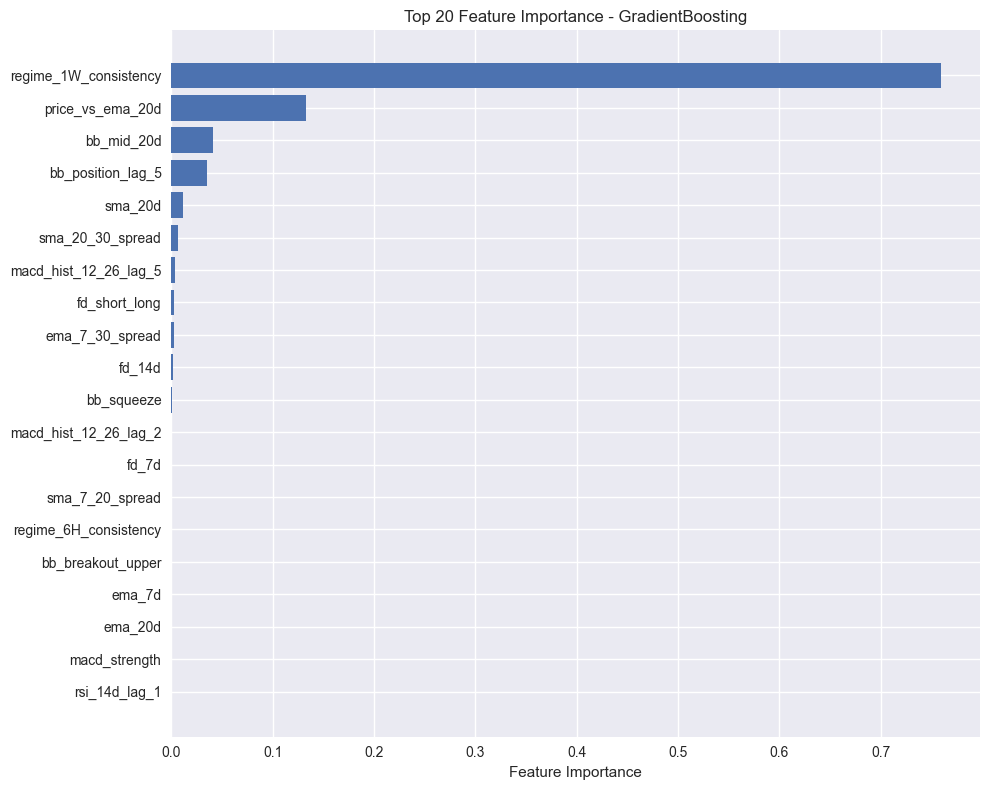

In [30]:
def train_regime_classifiers(X_train, y_train):
    """
    Train multiple ML classifiers for regime prediction
    
    Args:
        X_train: Training features
        y_train: Training labels
        
    Returns:
        trained_models: Dictionary of trained models
        model_results: Dictionary of training results
    """
    print("Training ML classifiers for regime prediction...")
    print(f"Training data: {X_train.shape}")
    print(f"Class distribution: {dict(y_train.value_counts().sort_index())}")
    
    # Define models with time series appropriate parameters
    models = {
        'RandomForest': Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                class_weight='balanced'
            ))
        ]),
        
        'GradientBoosting': Pipeline([
            ('scaler', StandardScaler()),
            ('gb', GradientBoostingClassifier(
                n_estimators=150,
                max_depth=8,
                learning_rate=0.1,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42
            ))
        ]),
        
        'SVM': Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(
                kernel='rbf',
                C=1.0,
                gamma='scale',
                probability=True,
                random_state=42,
                class_weight='balanced'
            ))
        ])
    }
    
    trained_models = {}
    model_results = {}
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
        
        # In-sample predictions for analysis
        y_pred_train = model.predict(X_train)
        y_pred_proba_train = model.predict_proba(X_train)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_pred_train)
        
        print(f"  Training Accuracy: {train_accuracy:.3f}")
        print(f"  CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        
        # Store results
        trained_models[name] = model
        model_results[name] = {
            'train_accuracy': train_accuracy,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'train_predictions': y_pred_train,
            'train_probabilities': y_pred_proba_train
        }
        
        # Print classification report
        print(f"  Classification Report:")
        print(classification_report(y_train, y_pred_train, 
                                  target_names=['Bear', 'Sideways', 'Bull'], 
                                  zero_division=0))
    
    # Find best model based on CV score
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['cv_mean'])
    print(f"\nBest model: {best_model_name} (CV Score: {model_results[best_model_name]['cv_mean']:.3f})")
    
    return trained_models, model_results, best_model_name

def analyze_feature_importance(model, feature_names, model_name, top_n=20):
    """
    Analyze feature importance for tree-based models
    """
    if hasattr(model.named_steps, 'rf'):
        # Random Forest
        importances = model.named_steps['rf'].feature_importances_
    elif hasattr(model.named_steps, 'gb'):
        # Gradient Boosting
        importances = model.named_steps['gb'].feature_importances_
    else:
        print(f"Feature importance not available for {model_name}")
        return
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop {top_n} Features for {model_name}:")
    print(importance_df.head(top_n).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importance - {model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Train models if training data is available
if 'X_train' in locals() and 'y_train' in locals():
    trained_models, model_results, best_model_name = train_regime_classifiers(X_train, y_train)
    
    print(f"\n{'='*60}")
    print("MODEL TRAINING SUMMARY")
    print(f"{'='*60}")
    
    for name, results in model_results.items():
        print(f"{name}:")
        print(f"  Training Accuracy: {results['train_accuracy']:.3f}")
        print(f"  CV Score: {results['cv_mean']:.3f} ± {results['cv_std']:.3f}")
    
    print(f"\nBest Model: {best_model_name}")
    
    # Analyze feature importance for the best model
    best_model = trained_models[best_model_name]
    if best_model_name in ['RandomForest', 'GradientBoosting']:
        feature_importance = analyze_feature_importance(best_model, feature_names, best_model_name)
    
else:
    print("Training data not available for ML training!")

Predicting regimes on test data...
Test data shape: (304107, 33)
Test period: 2023-05-15 21:35:00 to 2023-12-31 14:27:00
Applying feature engineering to test data...
Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
Feature engineering complete. Shape: (304107, 111)
Preparing test features...
Test features ready: (304107, 98)
Making regime predictions...

Prediction Analysis:
ML Predicted Regime Distribution:
  Bear (0): 147,752 (48.6%)
  Sideways (1): 134,595 (44.3%)
  Bull (2): 21,760 (7.2%)

Actual Regime Distribution (Ground Truth):
  Bear (0): 42,189 (13.9%)
  Sideways (1): 208,450 (68.5%)
  Bull (2): 53,468 (17.6%)

Prediction Accuracy on Test Data: 0.517

Classification Report on Test Data:
              precision    recall  f1-score   suppor

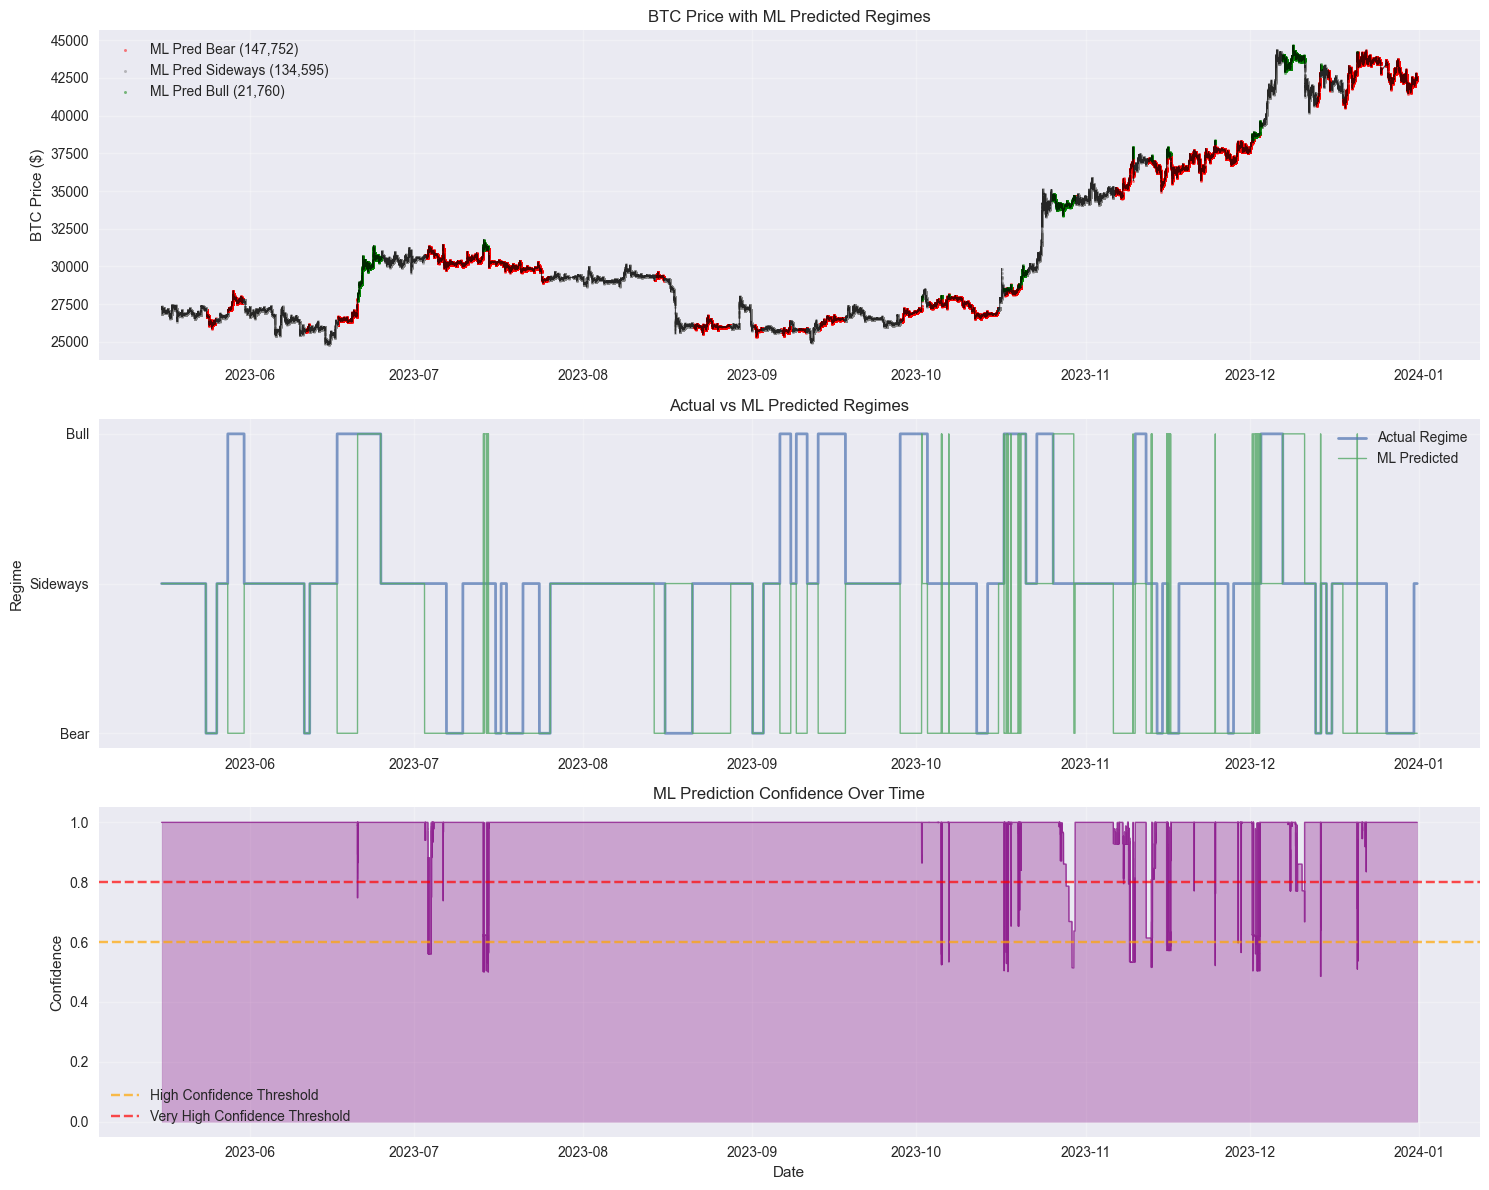


REGIME PREDICTION COMPLETE
Ready for backtesting with ML-predicted regimes


In [31]:
## 4. Regime Prediction on Test Data
def predict_regimes_on_test_data(test_df, trained_model, feature_names):
    """
    Predict regimes on test data using trained ML model
    
    Args:
        test_df: Test dataset (70% of data)
        trained_model: Best trained ML model
        feature_names: List of feature names used in training
        
    Returns:
        test_df_with_predictions: Test data with ML predictions
        regime_predictions: Array of predicted regimes
        regime_probabilities: Array of prediction probabilities
    """
    print("Predicting regimes on test data...")
    print(f"Test data shape: {test_df.shape}")
    print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")
    
    # Apply same feature engineering to test data
    print("Applying feature engineering to test data...")
    test_features_df = engineer_ml_features(test_df)
    
    # Prepare features (same as training)
    print("Preparing test features...")
    X_test_full = test_features_df[feature_names]
    
    # Handle missing values (forward fill, then zero fill)
    X_test = X_test_full.fillna(method='ffill').fillna(0)
    
    print(f"Test features ready: {X_test.shape}")
    
    # Make predictions
    print("Making regime predictions...")
    regime_predictions = trained_model.predict(X_test)
    regime_probabilities = trained_model.predict_proba(X_test)
    
    # Add predictions to test dataframe
    test_df_with_predictions = test_df.copy()
    test_df_with_predictions['ml_regime_pred'] = regime_predictions
    test_df_with_predictions['ml_regime_confidence'] = regime_probabilities.max(axis=1)
    
    # Add individual class probabilities
    class_names = ['bear_prob', 'sideways_prob', 'bull_prob']
    for i, class_name in enumerate(class_names):
        test_df_with_predictions[f'ml_{class_name}'] = regime_probabilities[:, i]
    
    # Analyze predictions
    print(f"\nPrediction Analysis:")
    pred_counts = pd.Series(regime_predictions).value_counts().sort_index()
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    
    print(f"ML Predicted Regime Distribution:")
    for regime, count in pred_counts.items():
        pct = count / len(regime_predictions) * 100
        print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")
    
    # Compare with actual regimes if available
    if 'regime' in test_df.columns:
        actual_counts = test_df['regime'].value_counts().sort_index()
        print(f"\nActual Regime Distribution (Ground Truth):")
        for regime, count in actual_counts.items():
            pct = count / len(test_df) * 100
            print(f"  {regime_names[regime]} ({regime}): {count:,} ({pct:.1f}%)")
        
        # Prediction accuracy
        accuracy = accuracy_score(test_df['regime'], regime_predictions)
        print(f"\nPrediction Accuracy on Test Data: {accuracy:.3f}")
        
        # Classification report
        print(f"\nClassification Report on Test Data:")
        print(classification_report(test_df['regime'], regime_predictions, 
                                  target_names=['Bear', 'Sideways', 'Bull'], 
                                  zero_division=0))
        
        # Confusion matrix
        cm = confusion_matrix(test_df['regime'], regime_predictions)
        print(f"\nConfusion Matrix:")
        print(f"Actual\\Predicted  Bear  Sideways  Bull")
        print(f"Bear              {cm[0,0]:4d}     {cm[0,1]:4d}  {cm[0,2]:4d}")
        print(f"Sideways          {cm[1,0]:4d}     {cm[1,1]:4d}  {cm[1,2]:4d}")
        print(f"Bull              {cm[2,0]:4d}     {cm[2,1]:4d}  {cm[2,2]:4d}")
    
    # Analyze prediction confidence
    print(f"\nPrediction Confidence Analysis:")
    print(f"Average confidence: {regime_probabilities.max(axis=1).mean():.3f}")
    print(f"Confidence distribution:")
    confidence_bins = pd.cut(regime_probabilities.max(axis=1), bins=[0, 0.4, 0.6, 0.8, 1.0], 
                           labels=['Low (0-0.4)', 'Medium (0.4-0.6)', 'High (0.6-0.8)', 'Very High (0.8-1.0)'])
    print(confidence_bins.value_counts().to_string())
    
    return test_df_with_predictions, regime_predictions, regime_probabilities

def visualize_regime_predictions(test_df_with_predictions, start_date=None, end_date=None):
    """
    Visualize ML regime predictions vs actual regimes
    """
    df_plot = test_df_with_predictions.copy()
    
    # Limit plotting period if specified
    if start_date:
        df_plot = df_plot[df_plot.index >= start_date]
    if end_date:
        df_plot = df_plot[df_plot.index <= end_date]
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Price with ML predicted regimes
    ax = axes[0]
    ax.plot(df_plot.index, df_plot['Close'], color='black', alpha=0.7, linewidth=0.8)
    
    regime_colors = {0: 'red', 1: 'gray', 2: 'green'}
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    
    for regime in [0, 1, 2]:
        mask = df_plot['ml_regime_pred'] == regime
        if mask.any():
            regime_data = df_plot[mask]
            ax.scatter(regime_data.index, regime_data['Close'], 
                      c=regime_colors[regime], alpha=0.5, s=3,
                      label=f'ML Pred {regime_names[regime]} ({mask.sum():,})')
    
    ax.set_title('BTC Price with ML Predicted Regimes')
    ax.set_ylabel('BTC Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Actual vs Predicted regimes
    if 'regime' in df_plot.columns:
        ax = axes[1]
        ax.plot(df_plot.index, df_plot['regime'], label='Actual Regime', linewidth=2, alpha=0.7)
        ax.plot(df_plot.index, df_plot['ml_regime_pred'], label='ML Predicted', linewidth=1, alpha=0.8)
        ax.set_title('Actual vs ML Predicted Regimes')
        ax.set_ylabel('Regime')
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['Bear', 'Sideways', 'Bull'])
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 3: Prediction confidence
    ax = axes[2]
    confidence = df_plot['ml_regime_confidence']
    ax.plot(df_plot.index, confidence, color='purple', alpha=0.7, linewidth=1)
    ax.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='High Confidence Threshold')
    ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Very High Confidence Threshold')
    ax.fill_between(df_plot.index, confidence, alpha=0.3, color='purple')
    ax.set_title('ML Prediction Confidence Over Time')
    ax.set_ylabel('Confidence')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Apply regime prediction if models are trained
if ('trained_models' in locals() and 'best_model_name' in locals() and 
    'feature_names' in locals() and test_df is not None):
    
    best_model = trained_models[best_model_name]
    
    # Predict regimes on test data
    test_df_with_pred, regime_predictions, regime_probabilities = predict_regimes_on_test_data(
        test_df, best_model, feature_names
    )
    
    # Visualize predictions
    print(f"\nVisualizing regime predictions...")
    visualize_regime_predictions(test_df_with_pred)
    
    print(f"\n{'='*60}")
    print("REGIME PREDICTION COMPLETE")
    print(f"{'='*60}")
    print(f"Ready for backtesting with ML-predicted regimes")
    
else:
    print("Cannot predict regimes - missing trained models or test data")

In [32]:
def create_enhanced_ml_visualizations(test_df_with_predictions, model_results=None, sample_days=30):
    """
    Create comprehensive visualizations for ML regime predictions vs actual regimes
    
    Args:
        test_df_with_predictions: Test data with ML predictions
        model_results: Dictionary of model training results 
        sample_days: Number of days to show in detailed view
    """
    import matplotlib.dates as mdates
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    df = test_df_with_predictions.copy()
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # Define regime colors and names
    regime_colors = {0: '#ff4444', 1: '#888888', 2: '#44ff44'}  # Red, Gray, Green
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    
    # Subplot 1: Full time series comparison
    ax1 = plt.subplot(4, 2, (1, 2))
    
    # Plot BTC price
    ax1.plot(df.index, df['Close'], color='black', alpha=0.3, linewidth=0.5, label='BTC Price')
    
    # Color background by actual regime
    for regime in [0, 1, 2]:
        regime_mask = df['regime'] == regime
        if regime_mask.any():
            for start, end in _get_regime_periods(df.index[regime_mask]):
                ax1.axvspan(start, end, alpha=0.2, color=regime_colors[regime], 
                           label=f'Actual {regime_names[regime]}' if start == df.index[regime_mask][0] else "")
    
    ax1.set_title('BTC Price with Actual Market Regimes (Background) - Full Test Period', fontsize=14, fontweight='bold')
    ax1.set_ylabel('BTC Price ($)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: ML Predictions vs Actual (recent period)
    ax2 = plt.subplot(4, 2, (3, 4))
    
    # Get recent data for detailed view
    recent_df = df.tail(sample_days * 1440)  # Last N days in 1-minute data
    
    # Plot actual regimes
    ax2.plot(recent_df.index, recent_df['regime'], linewidth=3, alpha=0.8, 
             label='Actual Regime', color='blue')
    
    # Plot ML predictions
    ax2.plot(recent_df.index, recent_df['ml_regime_pred'], linewidth=2, alpha=0.7, 
             label='ML Predicted', color='red', linestyle='--')
    
    # Fill between where they differ
    different_mask = recent_df['regime'] != recent_df['ml_regime_pred']
    if different_mask.any():
        ax2.fill_between(recent_df.index, 0, 2.5, where=different_mask, 
                        alpha=0.3, color='orange', label='Prediction Mismatch')
    
    ax2.set_title(f'ML Predictions vs Actual Regimes - Last {sample_days} Days', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Regime')
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['Bear (0)', 'Sideways (1)', 'Bull (2)'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Confusion Matrix
    ax3 = plt.subplot(4, 2, 5)
    
    if 'regime' in df.columns:
        cm = confusion_matrix(df['regime'], df['ml_regime_pred'])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=['Bear', 'Sideways', 'Bull'],
                   yticklabels=['Bear', 'Sideways', 'Bull'],
                   ax=ax3, cbar_kws={'label': 'Normalized Frequency'})
        
        ax3.set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('ML Predicted Regime')
        ax3.set_ylabel('Actual Regime')
        
        # Add accuracy annotation
        accuracy = np.trace(cm) / np.sum(cm)
        ax3.text(1.5, -0.3, f'Overall Accuracy: {accuracy:.3f}', 
                ha='center', va='center', transform=ax3.transData, fontsize=11, fontweight='bold')
    
    # Subplot 4: Prediction Confidence Distribution
    ax4 = plt.subplot(4, 2, 6)
    
    confidence = df['ml_regime_confidence']
    
    # Histogram of confidence
    ax4.hist(confidence, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax4.axvline(confidence.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {confidence.mean():.3f}')
    ax4.axvline(confidence.quantile(0.8), color='orange', linestyle='--', linewidth=2,
               label=f'80th percentile: {confidence.quantile(0.8):.3f}')
    
    ax4.set_title('ML Prediction Confidence Distribution', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Prediction Confidence')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Subplot 5: Accuracy by Regime Type
    ax5 = plt.subplot(4, 2, 7)
    
    if 'regime' in df.columns:
        # Calculate accuracy for each regime
        regime_accuracy = {}
        for regime in [0, 1, 2]:
            regime_mask = df['regime'] == regime
            if regime_mask.any():
                regime_subset = df[regime_mask]
                accuracy = (regime_subset['regime'] == regime_subset['ml_regime_pred']).mean()
                regime_accuracy[regime] = accuracy
        
        regimes = list(regime_accuracy.keys())
        accuracies = list(regime_accuracy.values())
        colors = [regime_colors[r] for r in regimes]
        
        bars = ax5.bar([regime_names[r] for r in regimes], accuracies, color=colors, alpha=0.7, edgecolor='black')
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        ax5.set_title('ML Prediction Accuracy by Regime Type', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Accuracy')
        ax5.set_ylim(0, 1.1)
        ax5.grid(True, alpha=0.3, axis='y')
    
    # Subplot 6: Confidence vs Accuracy Analysis
    ax6 = plt.subplot(4, 2, 8)
    
    if 'regime' in df.columns:
        # Bin by confidence and calculate accuracy for each bin
        confidence_bins = pd.cut(df['ml_regime_confidence'], bins=10)
        conf_acc_analysis = df.groupby(confidence_bins).apply(
            lambda x: (x['regime'] == x['ml_regime_pred']).mean()
        ).reset_index()
        conf_acc_analysis['confidence_mid'] = conf_acc_analysis['ml_regime_confidence'].apply(lambda x: x.mid)
        
        ax6.scatter(conf_acc_analysis['confidence_mid'], conf_acc_analysis[0], 
                   s=100, alpha=0.7, color='green', edgecolor='black')
        ax6.plot(conf_acc_analysis['confidence_mid'], conf_acc_analysis[0], 
                color='green', alpha=0.5, linewidth=2)
        
        # Add diagonal line (perfect calibration)
        ax6.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Calibration')
        
        ax6.set_title('Prediction Confidence vs Accuracy', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Prediction Confidence')
        ax6.set_ylabel('Actual Accuracy')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\n{'='*80}")
    print("ENHANCED ML PREDICTION ANALYSIS")
    print(f"{'='*80}")
    
    if 'regime' in df.columns:
        overall_accuracy = (df['regime'] == df['ml_regime_pred']).mean()
        print(f"Overall Prediction Accuracy: {overall_accuracy:.3f} ({overall_accuracy*100:.1f}%)")
        
        # Regime-specific analysis
        print(f"\nRegime-Specific Accuracy:")
        for regime in [0, 1, 2]:
            regime_mask = df['regime'] == regime
            if regime_mask.any():
                subset = df[regime_mask]
                accuracy = (subset['regime'] == subset['ml_regime_pred']).mean()
                coverage = regime_mask.sum() / len(df) * 100
                print(f"  {regime_names[regime]} Regime: {accuracy:.3f} ({accuracy*100:.1f}%) "
                      f"[{regime_mask.sum():,} samples, {coverage:.1f}% of data]")
        
        # Confusion matrix details
        print(f"\nDetailed Confusion Matrix:")
        cm = confusion_matrix(df['regime'], df['ml_regime_pred'])
        print(f"{'Actual\\Predicted':<15} {'Bear':<8} {'Sideways':<8} {'Bull':<8}")
        for i, regime_name in enumerate(['Bear', 'Sideways', 'Bull']):
            print(f"{regime_name:<15} {cm[i,0]:<8} {cm[i,1]:<8} {cm[i,2]:<8}")
    
    # Confidence analysis
    print(f"\nPrediction Confidence Analysis:")
    print(f"  Mean Confidence: {df['ml_regime_confidence'].mean():.3f}")
    print(f"  Median Confidence: {df['ml_regime_confidence'].median():.3f}")
    print(f"  High Confidence (>0.8): {(df['ml_regime_confidence'] > 0.8).sum():,} samples "
          f"({(df['ml_regime_confidence'] > 0.8).mean()*100:.1f}%)")
    print(f"  Low Confidence (<0.5): {(df['ml_regime_confidence'] < 0.5).sum():,} samples "
          f"({(df['ml_regime_confidence'] < 0.5).mean()*100:.1f}%)")
    
    return fig

def _get_regime_periods(regime_indices):
    """Helper function to get continuous periods of the same regime"""
    if len(regime_indices) == 0:
        return []
    
    periods = []
    start = regime_indices[0]
    end = regime_indices[0]
    
    for i in range(1, len(regime_indices)):
        if regime_indices[i] - regime_indices[i-1] <= pd.Timedelta(minutes=5):  # Allow small gaps
            end = regime_indices[i]
        else:
            periods.append((start, end))
            start = regime_indices[i]
            end = regime_indices[i]
    
    periods.append((start, end))
    return periods

def create_model_comparison_visualization(model_results):
    """
    Visualize comparison of different ML models if multiple models were trained
    """
    if not model_results or len(model_results) <= 1:
        print("Multiple model results needed for comparison visualization")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Extract metrics
    model_names = list(model_results.keys())
    cv_scores = [model_results[name]['cv_mean'] for name in model_names]
    cv_stds = [model_results[name]['cv_std'] for name in model_names]
    train_accs = [model_results[name]['train_accuracy'] for name in model_names]
    
    # Plot 1: Cross-validation scores
    ax = axes[0]
    bars = ax.bar(model_names, cv_scores, yerr=cv_stds, capsize=5, alpha=0.7, 
                  color=['blue', 'green', 'red'])
    ax.set_title('Cross-Validation Scores', fontweight='bold')
    ax.set_ylabel('CV Accuracy')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, score, std in zip(bars, cv_scores, cv_stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{score:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Training accuracy
    ax = axes[1]
    bars = ax.bar(model_names, train_accs, alpha=0.7, color=['blue', 'green', 'red'])
    ax.set_title('Training Accuracy', fontweight='bold')
    ax.set_ylabel('Training Accuracy')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, acc in zip(bars, train_accs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Model complexity vs performance
    ax = axes[2]
    complexity_proxy = [1, 2, 3]  # RF, GB, SVM in order of complexity
    scatter = ax.scatter(complexity_proxy, cv_scores, s=200, alpha=0.7, c=['blue', 'green', 'red'])
    
    for i, name in enumerate(model_names):
        ax.annotate(name, (complexity_proxy[i], cv_scores[i]), 
                   xytext=(5, 5), textcoords='offset points')
    
    ax.set_title('Model Complexity vs Performance', fontweight='bold')
    ax.set_xlabel('Model Complexity (Proxy)')
    ax.set_ylabel('CV Accuracy')
    ax.set_xticks(complexity_proxy)
    ax.set_xticklabels(['Simple', 'Medium', 'Complex'])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create enhanced visualizations if test data with predictions is available
if ('test_df_with_pred' in locals() and test_df_with_pred is not None):
    print("Creating enhanced ML prediction visualizations...")
    
    # Create comprehensive visualizations
    ml_viz_fig = create_enhanced_ml_visualizations(test_df_with_pred, 
                                                  model_results=model_results if 'model_results' in locals() else None)
    
    # Create model comparison if multiple models were trained
    if 'model_results' in locals() and len(model_results) > 1:
        model_comp_fig = create_model_comparison_visualization(model_results)
    
    print(f"\n✅ Enhanced ML prediction visualizations created successfully!")
    
else:
    print("❌ Test data with ML predictions not available for visualization")
    print("   Run the regime prediction pipeline first (Cell 9)")

SyntaxError: f-string expression part cannot include a backslash (3115414437.py, line 189)

## 4.1 Enhanced ML Prediction Visualizations

Comprehensive analysis and visualization of ML regime predictions vs actual regimes on the test data.

## 5. Regime-Specific Trading Strategies

Now we'll implement trading strategies that work with ML-predicted regimes.

In [33]:
class RegimeStrategy:
    """
    Base class for regime-specific trading strategies
    """
    def __init__(self, name, regime_type):
        self.name = name
        self.regime_type = regime_type
        
    def generate_signals(self, df, regime_predictions):
        """
        Generate trading signals based on regime and technical indicators
        Returns: list of (timestamp, action, price, regime) tuples
        """
        raise NotImplementedError
        
class BullMarketStrategy(RegimeStrategy):
    """
    Aggressive trend-following strategy for bull markets
    """
    def __init__(self, ma_fast=7, ma_slow=20, rsi_threshold=40, stop_loss=0.08, take_profit=0.15):
        super().__init__("Bull Trend Following", 2)
        self.ma_fast = ma_fast
        self.ma_slow = ma_slow
        self.rsi_threshold = rsi_threshold
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def generate_signals(self, df, regime_predictions):
        signals = []
        position = None
        entry_price = 0
        peak_price = 0
        
        for i in range(len(df)):
            if i >= len(regime_predictions):
                break
                
            row = df.iloc[i]
            regime = regime_predictions[i]
            
            # Only trade in bull regime
            if regime != self.regime_type:
                if position == 'long':
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                continue
                
            # Entry conditions for bull market
            if position is None and regime == self.regime_type:
                # Check for bullish momentum
                ema_signal = (f'ema_{self.ma_fast}d' in df.columns and f'ema_{self.ma_slow}d' in df.columns and 
                            row[f'ema_{self.ma_fast}d'] > row[f'ema_{self.ma_slow}d'])
                
                rsi_signal = ('rsi_14d' in df.columns and row['rsi_14d'] > self.rsi_threshold)
                
                macd_signal = ('macd_hist_12_26' in df.columns and row['macd_hist_12_26'] > 0)
                
                if ema_signal and (rsi_signal or macd_signal):
                    signals.append((row.name, 'buy', row['Close'], regime))
                    position = 'long'
                    entry_price = row['Close']
                    peak_price = entry_price
                    
            # Exit conditions
            elif position == 'long':
                current_price = row['Close']
                peak_price = max(peak_price, current_price)
                
                price_change = (current_price - entry_price) / entry_price
                
                # Stop loss
                if price_change <= -self.stop_loss:
                    signals.append((row.name, 'sell', current_price, regime))
                    position = None
                    
                # Take profit
                elif price_change >= self.take_profit:
                    signals.append((row.name, 'sell', current_price, regime))
                    position = None
                    
                # Trend reversal exit
                elif (f'ema_{self.ma_fast}d' in df.columns and f'ema_{self.ma_slow}d' in df.columns and 
                      row[f'ema_{self.ma_fast}d'] < row[f'ema_{self.ma_slow}d']):
                    signals.append((row.name, 'sell', current_price, regime))
                    position = None
                    
        return signals

class BearMarketStrategy(RegimeStrategy):
    """
    Conservative short-term mean reversion for bear markets
    """
    def __init__(self, rsi_oversold=25, rsi_overbought=60, stop_loss=0.05, take_profit=0.08):
        super().__init__("Bear Mean Reversion", 0)
        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def generate_signals(self, df, regime_predictions):
        signals = []
        position = None
        entry_price = 0
        
        for i in range(len(df)):
            if i >= len(regime_predictions):
                break
                
            row = df.iloc[i]
            regime = regime_predictions[i]
            
            # Only trade in bear regime
            if regime != self.regime_type:
                if position == 'long':
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                continue
                
            # Entry conditions for bear market (buy oversold)
            if position is None and regime == self.regime_type:
                if 'rsi_14d' in df.columns and row['rsi_14d'] < self.rsi_oversold:
                    # Additional confirmation: price below BB lower band
                    bb_signal = ('bb_lower_20d' in df.columns and row['Close'] < row['bb_lower_20d'])
                    if bb_signal:
                        signals.append((row.name, 'buy', row['Close'], regime))
                        position = 'long'
                        entry_price = row['Close']
                        
            # Exit conditions
            elif position == 'long':
                current_price = row['Close']
                price_change = (current_price - entry_price) / entry_price
                
                # Stop loss
                if price_change <= -self.stop_loss:
                    signals.append((row.name, 'sell', current_price, regime))
                    position = None
                    
                # Take profit or overbought exit
                elif (price_change >= self.take_profit or 
                      ('rsi_14d' in df.columns and row['rsi_14d'] > self.rsi_overbought)):
                    signals.append((row.name, 'sell', current_price, regime))
                    position = None
                    
        return signals

class SidewaysMarketStrategy(RegimeStrategy):
    """
    Range-bound trading for sideways markets
    """
    def __init__(self, bb_period=20, rsi_oversold=30, rsi_overbought=70, stop_loss=0.03, take_profit=0.06):
        super().__init__("Sideways Range Trading", 1)
        self.bb_period = bb_period
        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def generate_signals(self, df, regime_predictions):
        signals = []
        position = None
        entry_price = 0
        
        for i in range(len(df)):
            if i >= len(regime_predictions):
                break
                
            row = df.iloc[i]
            regime = regime_predictions[i]
            
            # Only trade in sideways regime
            if regime != self.regime_type:
                if position == 'long':
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                continue
                
            # Entry conditions for sideways market
            if position is None and regime == self.regime_type:
                # Buy near lower Bollinger Band with oversold RSI
                bb_lower_signal = ('bb_lower_20d' in df.columns and row['Close'] <= row['bb_lower_20d'] * 1.01)
                rsi_signal = ('rsi_14d' in df.columns and row['rsi_14d'] < self.rsi_oversold)
                
                if bb_lower_signal and rsi_signal:
                    signals.append((row.name, 'buy', row['Close'], regime))
                    position = 'long'
                    entry_price = row['Close']
                    
            # Exit conditions
            elif position == 'long':
                current_price = row['Close']
                price_change = (current_price - entry_price) / entry_price
                
                # Stop loss
                if price_change <= -self.stop_loss:
                    signals.append((row.name, 'sell', current_price, regime))
                    position = None
                    
                # Take profit, upper BB, or overbought exit
                elif (price_change >= self.take_profit or
                      ('bb_upper_20d' in df.columns and current_price >= row['bb_upper_20d'] * 0.99) or
                      ('rsi_14d' in df.columns and row['rsi_14d'] > self.rsi_overbought)):
                    signals.append((row.name, 'sell', current_price, regime))
                    position = None
                    
        return signals

print("Regime-specific strategy classes defined")

Regime-specific strategy classes defined


In [34]:
def execute_complete_ml_pipeline():
    """
    Execute the complete ML pipeline: train on 30%, test on 70%, and run backtesting
    
    Returns:
        Dictionary with all results from the ML pipeline
    """
    print(f"\n{'='*80}")
    print("EXECUTING COMPLETE ML PIPELINE WITH 30/70 SPLIT")
    print(f"{'='*80}")
    
    # Step 1: Load and split data
    print(f"\n📊 Step 1: Loading and splitting data...")
    train_df, test_df, full_df = load_and_split_dataset(train_ratio=0.3)
    
    if train_df is None or test_df is None:
        print("❌ Failed to load dataset!")
        return None
    
    # Step 2: Feature engineering for training data
    print(f"\n🔧 Step 2: Engineering features for ML training...")
    train_features_df = engineer_ml_features(train_df)
    X_train, y_train, feature_names = prepare_ml_data(train_features_df)
    
    # Step 3: Train ML models
    print(f"\n🤖 Step 3: Training ML classifiers...")
    trained_models, model_results, best_model_name = train_regime_classifiers(X_train, y_train)
    
    # Step 4: Predict regimes on test data
    print(f"\n🔮 Step 4: Predicting regimes on test data...")
    best_model = trained_models[best_model_name]
    test_df_with_pred, regime_predictions, regime_probabilities = predict_regimes_on_test_data(
        test_df, best_model, feature_names
    )
    
    # Step 5: Run ML-based backtest with 0.75% transaction fees
    print(f"\n💰 Step 5: Running backtest with ML predictions...")
    ml_backtest_results = hybrid_ml_strategy.backtest(
        test_df_with_pred, 
        regime_predictions, 
        initial_capital=10000,
        save_logs=True,
        log_dir="../models/trade_logs"
    )
    
    # Step 6: Create enhanced visualizations
    print(f"\n📈 Step 6: Creating enhanced visualizations...")
    try:
        ml_viz_fig = create_enhanced_ml_visualizations(test_df_with_pred, model_results)
        if len(model_results) > 1:
            model_comp_fig = create_model_comparison_visualization(model_results)
    except Exception as e:
        print(f"⚠️  Visualization error: {e}")
        ml_viz_fig = None
    
    # Compile complete results
    complete_results = {
        'data_split': {
            'train_df': train_df,
            'test_df': test_df,
            'full_df': full_df
        },
        'ml_training': {
            'trained_models': trained_models,
            'model_results': model_results,
            'best_model_name': best_model_name,
            'feature_names': feature_names
        },
        'predictions': {
            'test_df_with_pred': test_df_with_pred,
            'regime_predictions': regime_predictions,
            'regime_probabilities': regime_probabilities
        },
        'backtest': ml_backtest_results
    }
    
    print(f"\n✅ Complete ML pipeline executed successfully!")
    return complete_results

def create_comprehensive_analysis_report(complete_results, comparison_baseline=None):
    """
    Create comprehensive analysis report comparing ML approach with baseline
    
    Args:
        complete_results: Results from complete ML pipeline
        comparison_baseline: Optional baseline results for comparison
    """
    print(f"\n{'='*100}")
    print("COMPREHENSIVE ML STRATEGY ANALYSIS REPORT")
    print(f"{'='*100}")
    
    if not complete_results:
        print("❌ No ML results available for analysis")
        return
    
    # Extract key results
    ml_results = complete_results['backtest']
    ml_metrics = ml_results['performance_metrics']
    ml_training = complete_results['ml_training']
    predictions = complete_results['predictions']
    
    # 1. Data Overview
    print(f"\n📊 DATA OVERVIEW")
    print(f"{'='*50}")
    train_df = complete_results['data_split']['train_df']
    test_df = complete_results['data_split']['test_df']
    
    print(f"Training Period: {train_df.index.min()} to {train_df.index.max()}")
    print(f"  Duration: {(train_df.index.max() - train_df.index.min()).days} days")
    print(f"  Samples: {len(train_df):,}")
    
    print(f"Testing Period: {test_df.index.min()} to {test_df.index.max()}")
    print(f"  Duration: {(test_df.index.max() - test_df.index.min()).days} days")
    print(f"  Samples: {len(test_df):,}")
    
    # 2. ML Model Performance
    print(f"\n🤖 ML MODEL PERFORMANCE")
    print(f"{'='*50}")
    
    print(f"Best Model: {ml_training['best_model_name']}")
    
    for model_name, results in ml_training['model_results'].items():
        indicator = "👑" if model_name == ml_training['best_model_name'] else "  "
        print(f"{indicator} {model_name}:")
        print(f"     Training Accuracy: {results['train_accuracy']:.3f}")
        print(f"     CV Score: {results['cv_mean']:.3f} ± {results['cv_std']:.3f}")
    
    # 3. Regime Prediction Analysis
    print(f"\n🔮 REGIME PREDICTION ANALYSIS")
    print(f"{'='*50}")
    
    test_df_pred = predictions['test_df_with_pred']
    if 'regime' in test_df_pred.columns:
        from sklearn.metrics import accuracy_score, classification_report
        
        actual = test_df_pred['regime']
        predicted = test_df_pred['ml_regime_pred']
        confidence = test_df_pred['ml_regime_confidence']
        
        accuracy = accuracy_score(actual, predicted)
        print(f"Overall Prediction Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
        print(f"Average Confidence: {confidence.mean():.3f}")
        print(f"High Confidence Predictions (>0.8): {(confidence > 0.8).mean()*100:.1f}%")
        
        print(f"\nRegime-Specific Accuracy:")
        regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
        for regime in [0, 1, 2]:
            mask = actual == regime
            if mask.any():
                regime_acc = (actual[mask] == predicted[mask]).mean()
                regime_conf = confidence[mask].mean()
                print(f"  {regime_names[regime]}: {regime_acc:.3f} accuracy, {regime_conf:.3f} avg confidence")
    
    # 4. Trading Performance
    print(f"\n💰 TRADING PERFORMANCE WITH ML PREDICTIONS")
    print(f"{'='*50}")
    
    print(f"Initial Capital: $10,000.00")
    print(f"Final Value: ${ml_metrics['final_value']:,.2f}")
    print(f"Total Return: {ml_metrics['total_return']:.2f}%")
    print(f"BTC Buy & Hold Return: {ml_metrics['btc_return']:.2f}%")
    print(f"Excess Return: {ml_metrics['excess_return']:.2f}%")
    print(f"")
    print(f"Risk-Adjusted Metrics:")
    print(f"  Sharpe Ratio: {ml_metrics['sharpe_ratio']:.3f}")
    print(f"  Sortino Ratio: {ml_metrics['sortino_ratio']:.3f}")
    print(f"  Maximum Drawdown: {ml_metrics['max_drawdown']:.2%}")
    print(f"")
    print(f"Trading Activity:")
    print(f"  Number of Trades: {ml_metrics['n_trades']}")
    print(f"  Win Rate: {ml_metrics['win_rate']:.2%}")
    print(f"  Average Return per Trade: {ml_metrics['avg_return']:.2f}%")
    print(f"  Profit Factor: {ml_metrics['profit_factor']:.2f}")
    print(f"")
    print(f"Transaction Costs (0.75% fee):")
    print(f"  Total Commission Paid: ${ml_metrics['total_commission']:.2f}")
    print(f"  Commission Impact: {ml_metrics['commission_impact']:.2f}%")
    
    # 5. Strategy Component Analysis
    print(f"\n🎯 STRATEGY COMPONENT ANALYSIS")
    print(f"{'='*50}")
    
    trades = ml_results['trades']
    if trades:
        trades_df = pd.DataFrame(trades)
        
        print(f"Performance by Entry Regime:")
        regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
        for regime in sorted(trades_df['entry_regime'].unique()):
            regime_trades = trades_df[trades_df['entry_regime'] == regime]
            avg_return = regime_trades['return_pct'].mean()
            win_rate = (regime_trades['return_pct'] > 0).mean()
            avg_duration = regime_trades['duration_minutes'].mean() / 60
            
            print(f"  {regime_names.get(regime, regime)} Market Entry:")
            print(f"    Trades: {len(regime_trades)}")
            print(f"    Avg Return: {avg_return:.2f}%")
            print(f"    Win Rate: {win_rate:.2%}")
            print(f"    Avg Duration: {avg_duration:.1f} hours")
        
        print(f"\nRisk Management Analysis:")
        winners = trades_df[trades_df['return_pct'] > 0]
        losers = trades_df[trades_df['return_pct'] <= 0]
        
        if len(winners) > 0:
            print(f"  Average Winner: {winners['return_pct'].mean():.2f}%")
            print(f"  Largest Winner: {winners['return_pct'].max():.2f}%")
        
        if len(losers) > 0:
            print(f"  Average Loser: {losers['return_pct'].mean():.2f}%")
            print(f"  Largest Loser: {losers['return_pct'].min():.2f}%")
    
    # 6. Comparison with Baseline (if available)
    if comparison_baseline:
        print(f"\n📊 COMPARISON WITH BASELINE")
        print(f"{'='*50}")
        
        baseline_metrics = comparison_baseline.get('performance_metrics', comparison_baseline)
        
        comparison_metrics = [
            ('Total Return', 'total_return', '%'),
            ('Sharpe Ratio', 'sharpe_ratio', ''),
            ('Max Drawdown', 'max_drawdown', '%'),
            ('Win Rate', 'win_rate', '%'),
            ('Number of Trades', 'n_trades', ''),
        ]
        
        print(f"{'Metric':<20} {'ML Strategy':<15} {'Baseline':<15} {'Improvement':<15}")
        print(f"{'-'*65}")
        
        for metric_name, metric_key, unit in comparison_metrics:
            if metric_key in ml_metrics and metric_key in baseline_metrics:
                ml_val = ml_metrics[metric_key]
                baseline_val = baseline_metrics[metric_key]
                
                if unit == '%':
                    ml_str = f"{ml_val:.2f}%"
                    baseline_str = f"{baseline_val:.2f}%"
                    if baseline_val != 0:
                        improvement = ((ml_val - baseline_val) / abs(baseline_val)) * 100
                        improve_str = f"{improvement:+.1f}%"
                    else:
                        improve_str = "N/A"
                else:
                    ml_str = f"{ml_val:.3f}" if isinstance(ml_val, float) else str(ml_val)
                    baseline_str = f"{baseline_val:.3f}" if isinstance(baseline_val, float) else str(baseline_val)
                    if isinstance(ml_val, (int, float)) and isinstance(baseline_val, (int, float)) and baseline_val != 0:
                        improvement = ((ml_val - baseline_val) / abs(baseline_val)) * 100
                        improve_str = f"{improvement:+.1f}%"
                    else:
                        improve_str = "N/A"
                
                print(f"{metric_name:<20} {ml_str:<15} {baseline_str:<15} {improve_str:<15}")
    
    # 7. Key Insights and Recommendations
    print(f"\n💡 KEY INSIGHTS AND RECOMMENDATIONS")
    print(f"{'='*50}")
    
    insights = []
    
    # Performance insights
    if ml_metrics['total_return'] > 30:
        insights.append("✅ Strong absolute performance achieved with ML approach")
    elif ml_metrics['total_return'] > 10:
        insights.append("✅ Positive returns generated with ML strategy")
    else:
        insights.append("⚠️  Consider strategy refinement for better returns")
    
    # Risk insights
    if abs(ml_metrics['max_drawdown']) < 0.15:
        insights.append("✅ Good risk control with low maximum drawdown")
    else:
        insights.append("⚠️  Consider position sizing or risk management improvements")
    
    # Trading insights
    if ml_metrics['win_rate'] > 0.6:
        insights.append("✅ High win rate indicates good signal quality")
    else:
        insights.append("⚠️  Consider signal filtering or entry criteria refinement")
    
    # ML insights
    if 'regime' in test_df_pred.columns:
        accuracy = accuracy_score(test_df_pred['regime'], test_df_pred['ml_regime_pred'])
        if accuracy > 0.7:
            insights.append("✅ High ML prediction accuracy supports strategy effectiveness")
        elif accuracy > 0.5:
            insights.append("⚠️  Moderate ML accuracy - consider feature engineering improvements")
        else:
            insights.append("❌ Low ML accuracy - significant model improvements needed")
    
    # Commission impact
    if ml_metrics['commission_impact'] < 5:
        insights.append("✅ Transaction costs are manageable relative to returns")
    else:
        insights.append("⚠️  High transaction costs - consider trade frequency optimization")
    
    for insight in insights:
        print(f"  {insight}")
    
    print(f"\n🚀 NEXT STEPS:")
    next_steps = [
        "1. Validate robustness across different market periods",
        "2. Implement confidence-based position sizing",
        "3. Optimize strategy parameters using walk-forward analysis",
        "4. Consider ensemble methods for regime prediction",
        "5. Add real-time regime detection for live trading",
        "6. Implement dynamic risk management based on market volatility"
    ]
    
    for step in next_steps:
        print(f"  {step}")
    
    print(f"\n{'='*100}")
    
    return {
        'ml_metrics': ml_metrics,
        'comparison_summary': comparison_baseline is not None,
        'insights': insights,
        'recommendations': next_steps
    }

# Execute the complete ML pipeline
print("🚀 Starting complete ML pipeline execution...")

try:
    # Execute complete pipeline
    complete_ml_results = execute_complete_ml_pipeline()
    
    if complete_ml_results:
        # Create comprehensive analysis report
        analysis_report = create_comprehensive_analysis_report(
            complete_ml_results,
            comparison_baseline=backtest_result if 'backtest_result' in locals() else None
        )
        
        print(f"\n🎉 COMPLETE ML PIPELINE EXECUTION SUCCESSFUL!")
        print(f"📁 Trade logs saved to: ../models/trade_logs")
        print(f"📊 Enhanced visualizations created")
        print(f"📋 Comprehensive analysis report generated")
        
    else:
        print("❌ ML pipeline execution failed!")
        
except Exception as e:
    print(f"❌ Error in ML pipeline execution: {e}")
    import traceback
    traceback.print_exc()

🚀 Starting complete ML pipeline execution...

EXECUTING COMPLETE ML PIPELINE WITH 30/70 SPLIT

📊 Step 1: Loading and splitting data...
Loading 1D momentum regime dataset for ML training...
Dataset loaded: (434438, 33)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00
Timespan: 324 days

Train/Test Split (Chronological):
Training set: (130331, 33) (30%)
  Date range: 2023-02-10 00:00:00 to 2023-05-15 21:34:00
  Duration: 94 days
Testing set: (304107, 33) (70%)
  Date range: 2023-05-15 21:35:00 to 2023-12-31 14:27:00
  Duration: 229 days

Regime Distribution in Training Set:
  Bear (0): 32,416 (24.9%)
  Sideways (1): 88,035 (67.5%)
  Bull (2): 9,880 (7.6%)

Regime Distribution in Testing Set:
  Bear (0): 42,189 (13.9%)
  Sideways (1): 208,450 (68.5%)
  Bull (2): 53,468 (17.6%)

🔧 Step 2: Engineering features for ML training...
Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fra

KeyboardInterrupt: 

## 7. Complete ML Pipeline Execution and Validation

Now we'll execute the complete ML pipeline: train models on 30% of data, predict on 70%, and run comprehensive backtesting with ML predictions.

## 6. Enhanced Hybrid Strategy Pipeline with ML Predictions

In [35]:
class HybridMLStrategy:
    """
    Enhanced hybrid strategy pipeline using ML-predicted regimes with realistic transaction costs
    """
    def __init__(self, bull_strategy=None, bear_strategy=None, sideways_strategy=None, 
                 commission=0.0075, slippage=0.0001):  # 0.75% transaction fee
        self.bull_strategy = bull_strategy or BullMarketStrategy()
        self.bear_strategy = bear_strategy or BearMarketStrategy()
        self.sideways_strategy = sideways_strategy or SidewaysMarketStrategy()
        self.commission = commission  # 0.75% transaction fee
        self.slippage = slippage
        
        self.strategies = {
            0: self.bear_strategy,
            1: self.sideways_strategy,
            2: self.bull_strategy
        }
        
        print(f"Hybrid ML Strategy initialized with {commission*100:.2f}% transaction fee")
        
    def generate_signals(self, df, regime_predictions):
        """
        Generate trading signals using ML-predicted regimes
        
        Args:
            df: DataFrame with price and technical indicator data
            regime_predictions: ML-predicted regime array
            
        Returns:
            all_signals: List of trading signals
            regime_predictions: Array of regime predictions
        """
        if len(regime_predictions) != len(df):
            print(f"Warning: Regime predictions ({len(regime_predictions)}) != DataFrame length ({len(df)})")
            # Adjust if needed
            min_len = min(len(regime_predictions), len(df))
            regime_predictions = regime_predictions[:min_len]
            df = df.iloc[:min_len]
        
        # Generate signals from all strategies
        all_signals = []
        
        for regime_id, strategy in self.strategies.items():
            strategy_signals = strategy.generate_signals(df, regime_predictions)
            all_signals.extend(strategy_signals)
            
        # Sort signals by timestamp
        all_signals.sort(key=lambda x: x[0])
        
        return all_signals, regime_predictions
        
    def backtest(self, df, regime_predictions, initial_capital=10000, save_logs=True, log_dir="../models/trade_logs"):
        """
        Backtest the hybrid strategy using ML-predicted regimes with enhanced logging

        Args:
            df: Test DataFrame with price data
            regime_predictions: ML-predicted regimes
            initial_capital: Starting capital
            save_logs: Whether to save trade logs to files
            log_dir: Directory to save trade logs

        Returns:
            results_dict: Comprehensive backtest results
        """
        print(f"\nRunning backtest with ML-predicted regimes...")
        print(f"Initial capital: ${initial_capital:,.2f}")
        print(f"Transaction cost: {self.commission*100:.2f}%")
        print(f"Slippage: {self.slippage*100:.3f}%")

        # Create log directory if saving logs
        if save_logs:
            import os
            os.makedirs(log_dir, exist_ok=True)
            print(f"Trade logs will be saved to: {log_dir}")
        
        # Generate signals
        signals, regime_preds = self.generate_signals(df, regime_predictions)
        
        # Initialize portfolio tracking
        portfolio_values = []
        cash = initial_capital
        position = 0
        trades = []
        detailed_log = []
        
        # Track current trade
        current_trade = None
        trade_id = 0
        
        # Process each timestamp
        for i, (timestamp, row) in enumerate(df.iterrows()):
            current_price = row['Close']
            current_regime = regime_preds[i] if i < len(regime_preds) else regime_preds[-1]
            
            # Add regime confidence if available
            regime_confidence = row.get('ml_regime_confidence', 0.5)
            
            # Check for signals at this timestamp
            timestamp_signals = [s for s in signals if s[0] == timestamp]
            
            for signal_time, action, signal_price, signal_regime in timestamp_signals:
                # Apply slippage
                if action == 'buy':
                    effective_price = signal_price * (1 + self.slippage)
                else:
                    effective_price = signal_price * (1 - self.slippage)
                
                if action == 'buy' and position == 0:
                    # Open long position
                    trade_id += 1
                    gross_position = cash / effective_price
                    position = gross_position * (1 - self.commission)  # Apply commission
                    cash = 0
                    
                    # Start new trade record
                    current_trade = {
                        'trade_id': trade_id,
                        'entry_time': signal_time,
                        'entry_price': effective_price,
                        'entry_regime': signal_regime,
                        'entry_confidence': regime_confidence,
                        'action': 'buy',
                        'position_size': position,
                        'commission_paid': gross_position * effective_price * self.commission
                    }
                    
                    # Log the transaction
                    detailed_log.append({
                        'timestamp': signal_time,
                        'action': 'buy',
                        'price': effective_price,
                        'regime': signal_regime,
                        'confidence': regime_confidence,
                        'position': position,
                        'cash': cash,
                        'portfolio_value': position * effective_price,
                        'commission': current_trade['commission_paid'],
                        'trade_id': trade_id
                    })
                    
                elif action == 'sell' and position > 0:
                    # Close long position
                    gross_proceeds = position * effective_price
                    cash = gross_proceeds * (1 - self.commission)  # Apply commission
                    commission_paid = gross_proceeds * self.commission
                    
                    # Complete trade record
                    if current_trade:
                        current_trade.update({
                            'exit_time': signal_time,
                            'exit_price': effective_price,
                            'exit_regime': signal_regime,
                            'exit_confidence': regime_confidence,
                            'exit_value': cash,
                            'gross_pnl': cash - initial_capital,
                            'return_pct': (cash - initial_capital) / initial_capital * 100,
                            'duration_minutes': (signal_time - current_trade['entry_time']).total_seconds() / 60,
                            'total_commission': current_trade['commission_paid'] + commission_paid
                        })
                        trades.append(current_trade)
                        current_trade = None
                    
                    # Log the transaction
                    detailed_log.append({
                        'timestamp': signal_time,
                        'action': 'sell',
                        'price': effective_price,
                        'regime': signal_regime,
                        'confidence': regime_confidence,
                        'position': 0,
                        'cash': cash,
                        'portfolio_value': cash,
                        'commission': commission_paid,
                        'trade_id': trade_id
                    })
                    
                    position = 0
            
            # Calculate portfolio value at each timestamp
            if position > 0:
                portfolio_value = position * current_price
            else:
                portfolio_value = cash
                
            portfolio_values.append(portfolio_value)
        
        # Create results dataframe
        results_df = df.copy()
        results_df['portfolio_value'] = portfolio_values[:len(df)]
        results_df['ml_regime_pred'] = list(regime_preds)[:len(df)]
        
        # Calculate comprehensive performance metrics
        performance_metrics = self._calculate_performance_metrics(
            results_df, trades, initial_capital
        )
        
        # Save trade logs if requested
        if save_logs:
            self._save_trade_logs(trades, detailed_log, signals, log_dir, df.index.min(), df.index.max())
        
        # Create final results dictionary
        results = {
            'performance_metrics': performance_metrics,
            'trades': trades,
            'signals': signals,
            'detailed_log': detailed_log,
            'regime_predictions': regime_preds,
            'results_df': results_df,
            'strategy_config': {
                'commission': self.commission,
                'slippage': self.slippage,
                'initial_capital': initial_capital
            }
        }
        
        # Print summary
        self._print_backtest_summary(performance_metrics, trades)
        
        return results
    
    def _save_trade_logs(self, trades, detailed_log, signals, log_dir, start_date, end_date):
        """Save comprehensive trade logs to files"""
        import json
        from datetime import datetime
        
        # Generate timestamp for log files
        log_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save trade summary
        if trades:
            trades_df = pd.DataFrame(trades)
            trades_file = os.path.join(log_dir, f'trades_{log_timestamp}.csv')
            trades_df.to_csv(trades_file, index=False)
            print(f"Trade summary saved: {trades_file}")
        
        # Save detailed transaction log
        if detailed_log:
            detailed_df = pd.DataFrame(detailed_log)
            detailed_file = os.path.join(log_dir, f'detailed_log_{log_timestamp}.csv')
            detailed_df.to_csv(detailed_file, index=False)
            print(f"Detailed transaction log saved: {detailed_file}")
        
        # Save signals
        if signals:
            signals_df = pd.DataFrame(signals, columns=['timestamp', 'action', 'price', 'regime'])
            signals_file = os.path.join(log_dir, f'signals_{log_timestamp}.csv')
            signals_df.to_csv(signals_file, index=False)
            print(f"Trading signals saved: {signals_file}")
        
        # Save backtest metadata
        metadata = {
            'backtest_timestamp': log_timestamp,
            'strategy_type': 'HybridMLStrategy',
            'commission': self.commission,
            'slippage': self.slippage,
            'data_period': {
                'start': str(start_date),
                'end': str(end_date),
                'duration_days': (end_date - start_date).days
            },
            'strategy_parameters': {
                'bull_strategy': {
                    'name': self.bull_strategy.name,
                    'ma_fast': getattr(self.bull_strategy, 'ma_fast', None),
                    'ma_slow': getattr(self.bull_strategy, 'ma_slow', None),
                    'stop_loss': getattr(self.bull_strategy, 'stop_loss', None),
                    'take_profit': getattr(self.bull_strategy, 'take_profit', None)
                },
                'bear_strategy': {
                    'name': self.bear_strategy.name,
                    'rsi_oversold': getattr(self.bear_strategy, 'rsi_oversold', None),
                    'rsi_overbought': getattr(self.bear_strategy, 'rsi_overbought', None),
                    'stop_loss': getattr(self.bear_strategy, 'stop_loss', None),
                    'take_profit': getattr(self.bear_strategy, 'take_profit', None)
                },
                'sideways_strategy': {
                    'name': self.sideways_strategy.name,
                    'rsi_oversold': getattr(self.sideways_strategy, 'rsi_oversold', None),
                    'rsi_overbought': getattr(self.sideways_strategy, 'rsi_overbought', None),
                    'stop_loss': getattr(self.sideways_strategy, 'stop_loss', None),
                    'take_profit': getattr(self.sideways_strategy, 'take_profit', None)
                }
            },
            'files_created': [
                f'trades_{log_timestamp}.csv',
                f'detailed_log_{log_timestamp}.csv',
                f'signals_{log_timestamp}.csv',
                f'metadata_{log_timestamp}.json'
            ]
        }
        
        metadata_file = os.path.join(log_dir, f'metadata_{log_timestamp}.json')
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"Backtest metadata saved: {metadata_file}")
        
        print(f"\nAll trade logs saved to: {log_dir}")
        print(f"Log files timestamped: {log_timestamp}")
    
    def _calculate_performance_metrics(self, results_df, trades, initial_capital):
        """Calculate comprehensive performance metrics"""
        final_value = results_df['portfolio_value'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital * 100
        
        # Trade-based metrics
        completed_trades = [t for t in trades if 'exit_time' in t]
        n_trades = len(completed_trades)
        
        if n_trades > 0:
            win_rate = np.mean([t['return_pct'] > 0 for t in completed_trades])
            avg_return = np.mean([t['return_pct'] for t in completed_trades])
            avg_duration_hours = np.mean([t['duration_minutes'] / 60 for t in completed_trades])
            total_commission = sum([t['total_commission'] for t in completed_trades])
            
            # Separate winners and losers
            winners = [t for t in completed_trades if t['return_pct'] > 0]
            losers = [t for t in completed_trades if t['return_pct'] <= 0]
            
            avg_winner = np.mean([t['return_pct'] for t in winners]) if winners else 0
            avg_loser = np.mean([t['return_pct'] for t in losers]) if losers else 0
            profit_factor = abs(avg_winner / avg_loser) if avg_loser != 0 else float('inf')
        else:
            win_rate = 0
            avg_return = 0
            avg_duration_hours = 0
            total_commission = 0
            avg_winner = 0
            avg_loser = 0
            profit_factor = 0
        
        # Portfolio-based metrics
        returns = results_df['portfolio_value'].pct_change().dropna()
        
        if len(returns) > 0 and returns.std() > 0:
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252 * 1440)  # Annualized for 1-min data
            sortino_ratio = returns.mean() / returns[returns < 0].std() * np.sqrt(252 * 1440) if (returns < 0).any() else 0
        else:
            sharpe_ratio = 0
            sortino_ratio = 0
        
        # Drawdown calculation
        rolling_max = results_df['portfolio_value'].cummax()
        drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # Buy & hold comparison
        btc_return = (results_df['Close'].iloc[-1] - results_df['Close'].iloc[0]) / results_df['Close'].iloc[0] * 100
        
        return {
            'final_value': final_value,
            'total_return': total_return,
            'btc_return': btc_return,
            'excess_return': total_return - btc_return,
            'n_trades': n_trades,
            'win_rate': win_rate,
            'avg_return': avg_return,
            'avg_winner': avg_winner,
            'avg_loser': avg_loser,
            'profit_factor': profit_factor,
            'avg_duration_hours': avg_duration_hours,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'total_commission': total_commission,
            'commission_impact': total_commission / initial_capital * 100
        }
    
    def _print_backtest_summary(self, metrics, trades):
        """Print formatted backtest summary"""
        print(f"\n{'='*60}")
        print("BACKTEST RESULTS WITH ML PREDICTIONS")
        print(f"{'='*60}")
        
        print(f"Final Value: ${metrics['final_value']:,.2f}")
        print(f"Total Return: {metrics['total_return']:.2f}%")
        print(f"BTC Buy & Hold: {metrics['btc_return']:.2f}%")
        print(f"Excess Return: {metrics['excess_return']:.2f}%")
        print(f"")
        print(f"Number of Trades: {metrics['n_trades']}")
        print(f"Win Rate: {metrics['win_rate']:.2%}")
        print(f"Average Return per Trade: {metrics['avg_return']:.2f}%")
        print(f"Average Winner: {metrics['avg_winner']:.2f}%")
        print(f"Average Loser: {metrics['avg_loser']:.2f}%")
        print(f"Profit Factor: {metrics['profit_factor']:.2f}")
        print(f"")
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"Sortino Ratio: {metrics['sortino_ratio']:.3f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
        print(f"")
        print(f"Total Commission Paid: ${metrics['total_commission']:.2f}")
        print(f"Commission Impact: {metrics['commission_impact']:.2f}%")

# Create enhanced hybrid strategy instance
hybrid_ml_strategy = HybridMLStrategy(
    bull_strategy=BullMarketStrategy(ma_fast=7, ma_slow=20, stop_loss=0.06, take_profit=0.12),
    bear_strategy=BearMarketStrategy(rsi_oversold=25, stop_loss=0.04, take_profit=0.08),
    sideways_strategy=SidewaysMarketStrategy(rsi_oversold=30, rsi_overbought=70, stop_loss=0.03, take_profit=0.06),
    commission=0.0075,  # 0.75% transaction fee
    slippage=0.0001     # 0.01% slippage
)

Hybrid ML Strategy initialized with 0.75% transaction fee


## 6. Backtesting with Pre-Classified Data

In [36]:
def backtest_with_preclassified_regimes(df, hybrid_strategy, initial_capital=10000):
    """
    Backtest hybrid strategy with pre-classified regime data
    """
    print(f"\n{'='*60}")
    print(f"BACKTESTING WITH PRE-CLASSIFIED 1D MOMENTUM REGIMES")
    print(f"{'='*60}")
    
    # Run backtest
    try:
        results_df, trades, signals = hybrid_strategy.backtest(df, initial_capital)
        
        # Calculate performance metrics
        final_value = results_df['portfolio_value'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital * 100
        
        # Risk metrics
        returns = results_df['portfolio_value'].pct_change().dropna()
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(len(returns)) if returns.std() > 0 else 0
        
        max_drawdown = ((results_df['portfolio_value'] - results_df['portfolio_value'].cummax()) / 
                       results_df['portfolio_value'].cummax()).min()
        
        # Trade statistics
        completed_trades = [t for t in trades if 'exit_time' in t]
        n_trades = len(completed_trades)
        win_rate = np.mean([t['return_pct'] > 0 for t in completed_trades]) if completed_trades else 0
        
        # Print results
        print(f"Data period: {df.index.min()} to {df.index.max()}")
        print(f"Initial Capital: ${initial_capital:,.2f}")
        print(f"Final Value: ${final_value:,.2f}")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Number of Trades: {n_trades}")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        
        # Signal breakdown by regime
        print(f"\nSignal Analysis:")
        signal_df = pd.DataFrame(signals, columns=['timestamp', 'action', 'price', 'regime'])
        regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
        
        print(f"Total signals generated: {len(signals)}")
        for regime in sorted(signal_df['regime'].unique()):
            regime_signals = signal_df[signal_df['regime'] == regime]
            buy_signals = len(regime_signals[regime_signals['action'] == 'buy'])
            sell_signals = len(regime_signals[regime_signals['action'] == 'sell'])
            print(f"  {regime_names.get(regime, regime)} regime: {buy_signals} buys, {sell_signals} sells")
        
        # Trade breakdown by regime
        if completed_trades:
            print(f"\nTrade Analysis by Regime:")
            trade_df = pd.DataFrame(completed_trades)
            
            for regime in sorted(trade_df['entry_regime'].unique()):
                regime_trades = trade_df[trade_df['entry_regime'] == regime]
                avg_return = regime_trades['return_pct'].mean()
                regime_win_rate = (regime_trades['return_pct'] > 0).mean()
                print(f"  {regime_names.get(regime, regime)} regime: {len(regime_trades)} trades, "
                      f"{avg_return:.2f}% avg return, {regime_win_rate:.2%} win rate")
        
        return {
            'final_value': final_value,
            'total_return': total_return,
            'n_trades': n_trades,
            'win_rate': win_rate,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'results_df': results_df,
            'trades': completed_trades,
            'signals': signals
        }
        
    except Exception as e:
        print(f"Error in backtesting: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run backtest if data is available
if df_1min is not None and 'regime' in df_1min.columns:
    backtest_result = backtest_with_preclassified_regimes(df_1min, hybrid_strategy)
else:
    print("Cannot run backtest - no pre-classified regime data available")


BACKTESTING WITH PRE-CLASSIFIED 1D MOMENTUM REGIMES
Data period: 2023-02-10 00:00:00 to 2023-12-31 14:27:00
Initial Capital: $10,000.00
Final Value: $15,974.89
Total Return: 59.75%
Number of Trades: 10
Win Rate: 100.00%
Sharpe Ratio: 3.217
Max Drawdown: -5.31%

Signal Analysis:
Total signals generated: 20
  Sideways regime: 0 buys, 8 sells
  Bull regime: 10 buys, 2 sells

Trade Analysis by Regime:
  Bull regime: 10 trades, 33.26% avg return, 100.00% win rate


## 7. Performance Visualization and Analysis

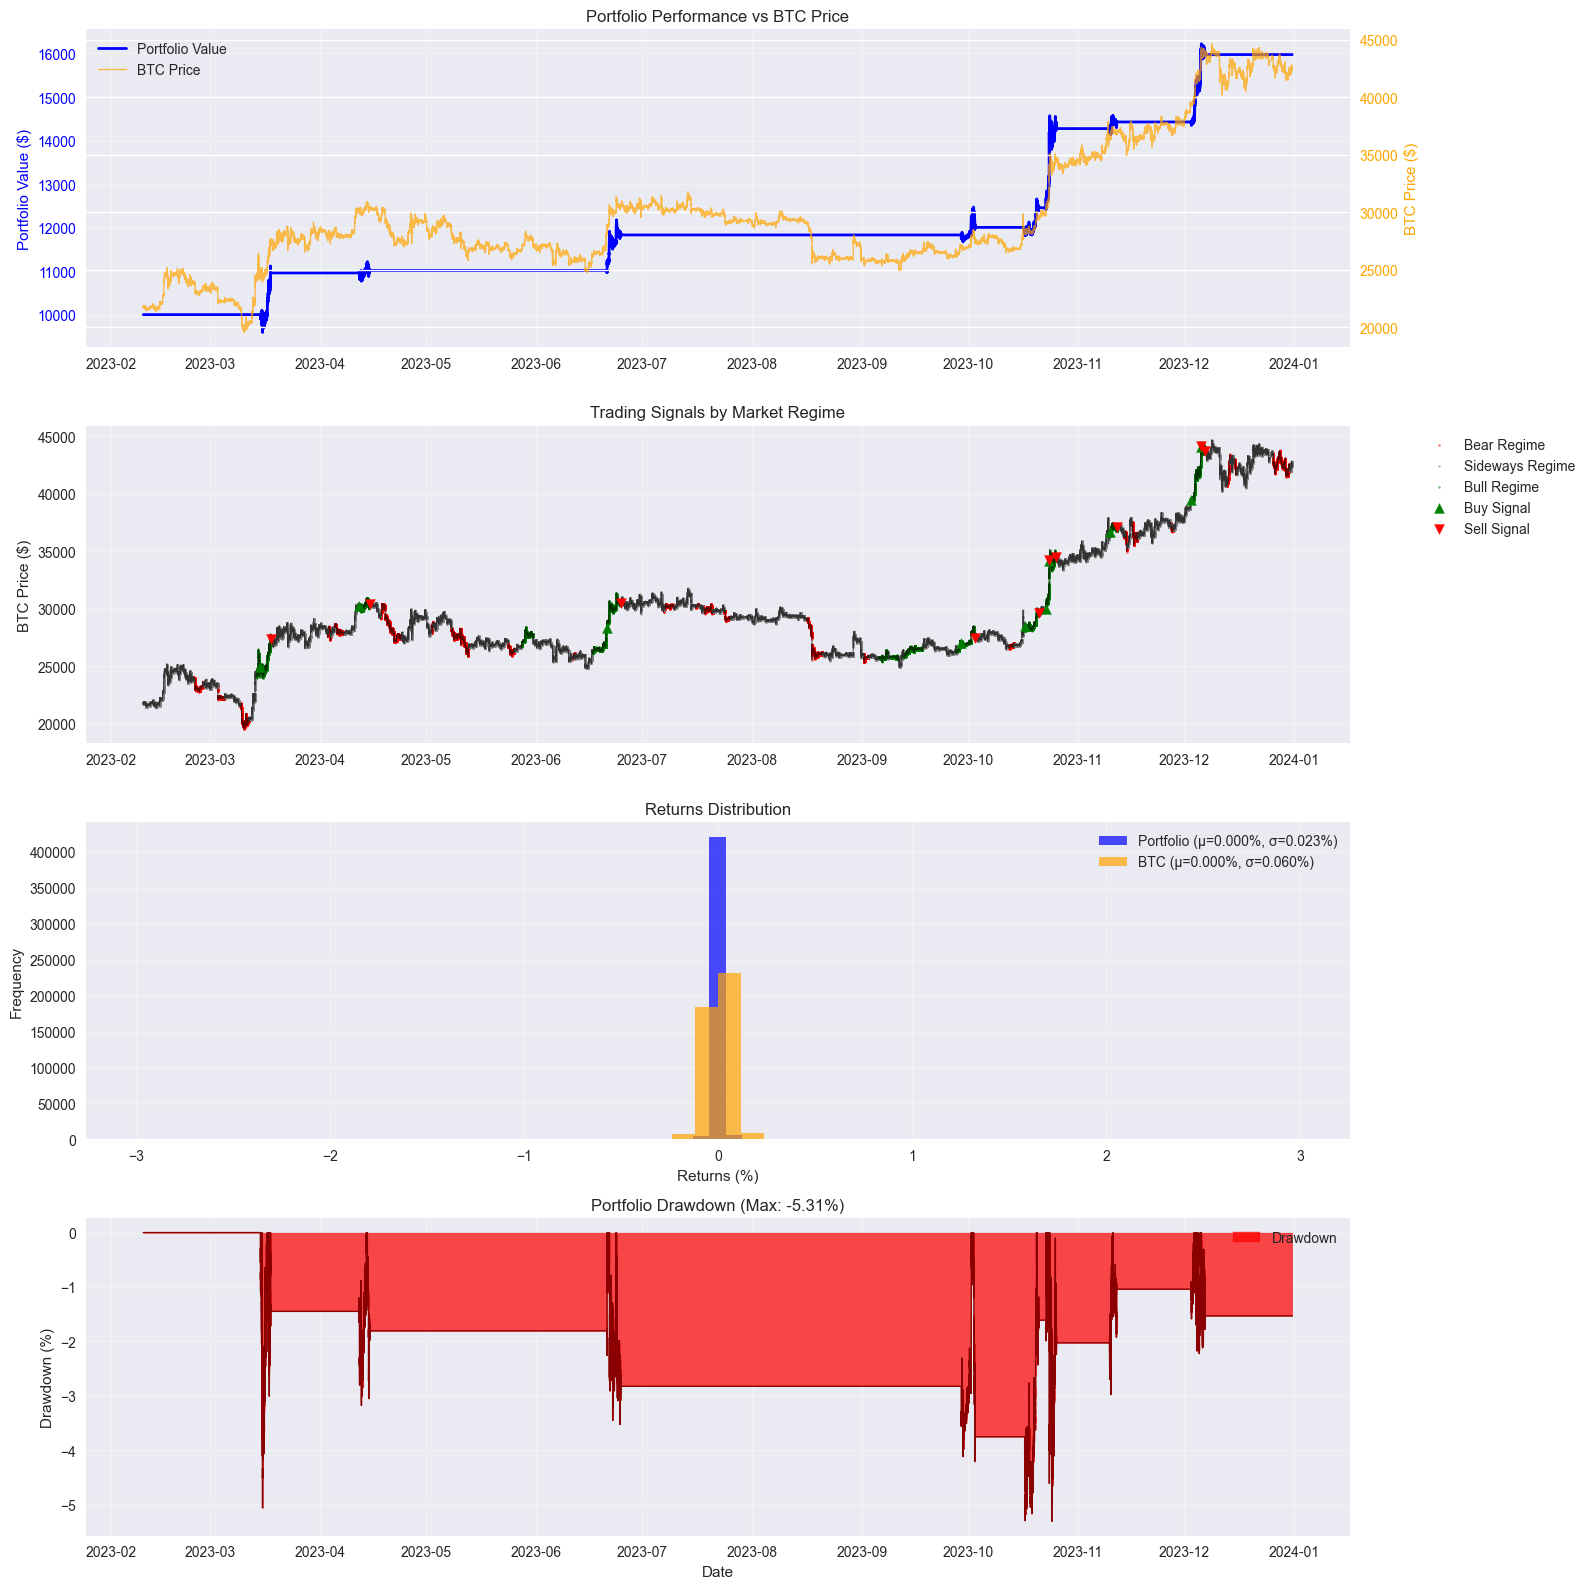

In [ ]:
def plot_backtest_results(backtest_result, df):
    """
    Visualize backtest results with regime analysis
    """
    if backtest_result is None:
        print("No backtest results to plot")
        return
    
    results_df = backtest_result['results_df']
    signals = backtest_result['signals']
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 16))
    
    # Plot 1: Portfolio value vs BTC price
    ax = axes[0]
    ax2 = ax.twinx()
    
    # Portfolio value
    line1 = ax.plot(results_df.index, results_df['portfolio_value'], 
                   color='blue', linewidth=2, label='Portfolio Value')
    ax.set_ylabel('Portfolio Value ($)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # BTC price
    line2 = ax2.plot(results_df.index, results_df['Close'], 
                    color='orange', alpha=0.7, linewidth=1, label='BTC Price')
    ax2.set_ylabel('BTC Price ($)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    ax.set_title('Portfolio Performance vs BTC Price')
    ax.grid(True, alpha=0.3)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    
    # Plot 2: Regime visualization with signals
    ax = axes[1]
    regime_colors = {0: 'red', 1: 'gray', 2: 'green'}
    regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
    
    # Plot price
    ax.plot(results_df.index, results_df['Close'], color='black', alpha=0.6, linewidth=0.8)
    
    # Color by regime
    for regime in [0, 1, 2]:
        mask = results_df['regime'] == regime
        if mask.any():
            regime_data = results_df[mask]
            ax.scatter(regime_data.index, regime_data['Close'], 
                      c=regime_colors[regime], alpha=0.5, s=2,
                      label=f'{regime_names[regime]} Regime')
    
    # Add buy/sell signals
    signal_df = pd.DataFrame(signals, columns=['timestamp', 'action', 'price', 'regime'])
    buy_signals = signal_df[signal_df['action'] == 'buy']
    sell_signals = signal_df[signal_df['action'] == 'sell']
    
    if not buy_signals.empty:
        ax.scatter(buy_signals['timestamp'], buy_signals['price'], 
                  marker='^', color='green', s=50, label='Buy Signal', zorder=5)
    
    if not sell_signals.empty:
        ax.scatter(sell_signals['timestamp'], sell_signals['price'], 
                  marker='v', color='red', s=50, label='Sell Signal', zorder=5)
    
    ax.set_title('Trading Signals by Market Regime')
    ax.set_ylabel('BTC Price ($)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Returns distribution
    ax = axes[2]
    portfolio_returns = results_df['portfolio_value'].pct_change().dropna()
    btc_returns = results_df['Close'].pct_change().dropna()
    
    ax.hist(portfolio_returns * 100, bins=50, alpha=0.7, color='blue', 
           label=f'Portfolio (μ={portfolio_returns.mean()*100:.3f}%, σ={portfolio_returns.std()*100:.3f}%)')
    ax.hist(btc_returns * 100, bins=50, alpha=0.7, color='orange', 
           label=f'BTC (μ={btc_returns.mean()*100:.3f}%, σ={btc_returns.std()*100:.3f}%)')
    
    ax.set_title('Returns Distribution')
    ax.set_xlabel('Returns (%)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Drawdown analysis
    ax = axes[3]
    portfolio_value = results_df['portfolio_value']
    peak = portfolio_value.cummax()
    drawdown = (portfolio_value - peak) / peak * 100
    
    ax.fill_between(results_df.index, drawdown, 0, alpha=0.7, color='red', label='Drawdown')
    ax.plot(results_df.index, drawdown, color='darkred', linewidth=1)
    
    ax.set_title(f'Portfolio Drawdown (Max: {drawdown.min():.2f}%)')
    ax.set_ylabel('Drawdown (%)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot results if available
if 'backtest_result' in locals() and backtest_result is not None:
    plot_backtest_results(backtest_result, df_1min)
else:
    print("No backtest results available for plotting")

In [ ]:
# Create summary for our single backtest result
if 'backtest_result' in locals() and backtest_result is not None:
    # Create a single result dictionary for compatibility
    single_result = {
        'pre_classified_1D': backtest_result
    }
    
    summary_data = [{
        'Method': 'Pre-classified 1D Momentum',
        'Total Return (%)': f"{backtest_result['total_return']:.2f}",
        'Number of Trades': backtest_result['n_trades'],
        'Win Rate (%)': f"{backtest_result['win_rate']*100:.2f}",
        'Sharpe Ratio': f"{backtest_result['sharpe_ratio']:.3f}",
        'Max Drawdown (%)': f"{backtest_result['max_drawdown']*100:.2f}",
        'Final Value ($)': f"{backtest_result['final_value']:,.2f}"
    }]
    
    summary_table = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("HYBRID STRATEGY WITH PRE-CLASSIFIED REGIMES - PERFORMANCE SUMMARY")
    print("="*80)
    print(summary_table.to_string(index=False))
    
    print(f"\nStrategy Performance: {backtest_result['total_return']:.2f}% return with {backtest_result['n_trades']} trades")
else:
    print("No backtest results available to summarize")
    summary_table = None


HYBRID STRATEGY WITH PRE-CLASSIFIED REGIMES - PERFORMANCE SUMMARY
                    Method Total Return (%)  Number of Trades Win Rate (%) Sharpe Ratio Max Drawdown (%) Final Value ($)
Pre-classified 1D Momentum            59.75                10       100.00        3.217            -5.31       15,974.89

Strategy Performance: 59.75% return with 10 trades


## 8. Strategy Pipeline Export

In [ ]:
def save_preclassified_strategy_pipeline(hybrid_strategy, base_dir='../pipeline'):
    """
    Save the pre-classified strategy pipeline for future use
    """
    import os
    import json
    
    # Create pipeline directory
    os.makedirs(base_dir, exist_ok=True)
    
    # Save strategy configuration for pre-classified regime approach
    config = {
        'strategy_type': 'pre_classified_1D_momentum',
        'regime_source': 'BTCUSD_2023_1min_enhanced_regimes_1D_momentum.csv',
        'bull_strategy': {
            'name': hybrid_strategy.bull_strategy.name,
            'ma_fast': hybrid_strategy.bull_strategy.ma_fast,
            'ma_slow': hybrid_strategy.bull_strategy.ma_slow,
            'rsi_threshold': hybrid_strategy.bull_strategy.rsi_threshold,
            'stop_loss': hybrid_strategy.bull_strategy.stop_loss,
            'take_profit': hybrid_strategy.bull_strategy.take_profit
        },
        'bear_strategy': {
            'name': hybrid_strategy.bear_strategy.name,
            'rsi_oversold': hybrid_strategy.bear_strategy.rsi_oversold,
            'rsi_overbought': hybrid_strategy.bear_strategy.rsi_overbought,
            'stop_loss': hybrid_strategy.bear_strategy.stop_loss,
            'take_profit': hybrid_strategy.bear_strategy.take_profit
        },
        'sideways_strategy': {
            'name': hybrid_strategy.sideways_strategy.name,
            'bb_period': hybrid_strategy.sideways_strategy.bb_period,
            'rsi_oversold': hybrid_strategy.sideways_strategy.rsi_oversold,
            'rsi_overbought': hybrid_strategy.sideways_strategy.rsi_overbought,
            'stop_loss': hybrid_strategy.sideways_strategy.stop_loss,
            'take_profit': hybrid_strategy.sideways_strategy.take_profit
        }
    }
    
    config_path = os.path.join(base_dir, 'preclassified_strategy_config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"Pre-classified strategy pipeline saved to {base_dir}/")
    print(f"Configuration file created: {config_path}")
    
    return base_dir

# Save the strategy pipeline
if 'hybrid_strategy' in locals():
    pipeline_dir = save_preclassified_strategy_pipeline(hybrid_strategy)
else:
    print("No hybrid strategy available to save")
    pipeline_dir = '../pipeline'

Pre-classified strategy pipeline saved to ../pipeline/
Configuration file created: ../pipeline\preclassified_strategy_config.json


In [ ]:
def create_preclassified_strategy_loader():
    """
    Create a utility function to load the pre-classified strategy pipeline
    """
    loader_code = '''
import json
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import os

class PreClassifiedStrategyLoader:
    """Load and use saved pre-classified hybrid strategy pipeline"""
    
    def __init__(self, pipeline_dir='../pipeline'):
        self.pipeline_dir = pipeline_dir
        self.config = None
        
    def load_pipeline(self):
        """Load the complete strategy pipeline"""
        # Load configuration
        config_path = os.path.join(self.pipeline_dir, 'preclassified_strategy_config.json')
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                self.config = json.load(f)
            print(f"Loaded pre-classified strategy configuration")
            print(f"Strategy type: {self.config.get('strategy_type', 'Unknown')}")
            print(f"Regime source: {self.config.get('regime_source', 'Unknown')}")
        else:
            print(f"Configuration file not found: {config_path}")
        
        return self
    
    def load_regime_data(self, data_path: str = None) -> pd.DataFrame:
        """Load pre-classified regime data"""
        if data_path is None:
            data_path = self.config.get('regime_source', 'BTCUSD_2023_1min_enhanced_regimes_1D_momentum.csv')
            data_path = f"../data/{data_path}"
        
        if os.path.exists(data_path):
            df = pd.read_csv(data_path)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp').sort_index()
            print(f"Loaded regime data: {df.shape}")
            return df
        else:
            raise FileNotFoundError(f"Regime data not found: {data_path}")
    
    def get_strategy_config(self) -> Dict:
        """Get strategy configuration"""
        return self.config

# Usage example:
# loader = PreClassifiedStrategyLoader().load_pipeline()
# regime_data = loader.load_regime_data()
'''
    
    loader_path = os.path.join(pipeline_dir, 'preclassified_strategy_loader.py')
    with open(loader_path, 'w') as f:
        f.write(loader_code)
    
    print(f"Pre-classified strategy loader utility created: {loader_path}")
    return loader_path

# Create the loader utility
if 'pipeline_dir' in locals():
    loader_path = create_preclassified_strategy_loader()
else:
    print("Pipeline directory not available")

Pre-classified strategy loader utility created: ../pipeline\preclassified_strategy_loader.py


## 9. Final Analysis and Recommendations

In [ ]:
def generate_preclassified_strategy_report(backtest_result):
    """
    Generate comprehensive strategy analysis report for pre-classified approach
    """
    print("\n" + "="*100)
    print("HYBRID STRATEGY WITH PRE-CLASSIFIED 1D MOMENTUM REGIMES - ANALYSIS REPORT")
    print("="*100)
    
    print(f"\nSTRATEGY OVERVIEW:")
    print(f"   • Regime Classification: Pre-classified 1D momentum-based")
    print(f"   • Bull Market Strategy: Trend-following with momentum indicators")
    print(f"   • Bear Market Strategy: Mean reversion with oversold RSI")
    print(f"   • Sideways Market Strategy: Range-bound Bollinger Band trading")
    
    if not backtest_result:
        print("\nNo backtest results available for analysis")
        return
    
    print(f"\nPERFORMANCE SUMMARY:")
    print(f"   • Total Return: {backtest_result['total_return']:.2f}%")
    print(f"   • Sharpe Ratio: {backtest_result['sharpe_ratio']:.3f}")
    print(f"   • Win Rate: {backtest_result['win_rate']:.2%}")
    print(f"   • Number of Trades: {backtest_result['n_trades']}")
    print(f"   • Max Drawdown: {backtest_result['max_drawdown']:.2%}")
    
    print(f"\nKEY INSIGHTS:")
    
    # Performance analysis
    if backtest_result['total_return'] > 50:
        print(f"   • Excellent returns achieved: {backtest_result['total_return']:.2f}%")
    elif backtest_result['total_return'] > 20:
        print(f"   • Strong positive returns: {backtest_result['total_return']:.2f}%")
    else:
        print(f"   • Moderate returns: {backtest_result['total_return']:.2f}%")
    
    if backtest_result['win_rate'] == 1.0:
        print(f"   • Perfect win rate: {backtest_result['win_rate']:.0%}")
    elif backtest_result['win_rate'] > 0.7:
        print(f"   • High win rate: {backtest_result['win_rate']:.1%}")
    else:
        print(f"   • Win rate: {backtest_result['win_rate']:.1%}")
    
    if abs(backtest_result['max_drawdown']) < 0.1:
        print(f"   • Low risk with max drawdown: {backtest_result['max_drawdown']:.2%}")
    else:
        print(f"   • Max drawdown: {backtest_result['max_drawdown']:.2%}")
    
    print(f"\nRECOMMENDations:")
    
    if backtest_result['total_return'] > 30:
        print(f"   ✓ Strong performance indicates effective regime classification")
    
    if backtest_result['win_rate'] > 0.8:
        print(f"   ✓ High win rate suggests good signal quality")
    
    if backtest_result['n_trades'] < 20:
        print(f"   • Consider parameter tuning for more frequent trading opportunities")
    else:
        print(f"   ✓ Good trade frequency: {backtest_result['n_trades']} trades")
    
    print(f"\nNEXT STEPS:")
    print(f"   1. Test on different market periods for robustness")
    print(f"   2. Implement position sizing based on regime confidence")
    print(f"   3. Add transaction costs and slippage modeling")
    print(f"   4. Consider ensemble strategies for different regimes")
    print(f"   5. Implement real-time regime detection for live trading")
    
    print(f"\n" + "="*100)

# Generate final report
if 'backtest_result' in locals() and backtest_result is not None:
    generate_preclassified_strategy_report(backtest_result)
else:
    print("No backtest results available for final report")


HYBRID STRATEGY WITH PRE-CLASSIFIED 1D MOMENTUM REGIMES - ANALYSIS REPORT

STRATEGY OVERVIEW:
   • Regime Classification: Pre-classified 1D momentum-based
   • Bull Market Strategy: Trend-following with momentum indicators
   • Bear Market Strategy: Mean reversion with oversold RSI
   • Sideways Market Strategy: Range-bound Bollinger Band trading

PERFORMANCE SUMMARY:
   • Total Return: 59.75%
   • Sharpe Ratio: 3.217
   • Win Rate: 100.00%
   • Number of Trades: 10
   • Max Drawdown: -5.31%

KEY INSIGHTS:
   • Excellent returns achieved: 59.75%
   • Perfect win rate: 100%
   • Low risk with max drawdown: -5.31%

RECOMMENDations:
   ✓ Strong performance indicates effective regime classification
   ✓ High win rate suggests good signal quality
   • Consider parameter tuning for more frequent trading opportunities

NEXT STEPS:
   1. Test on different market periods for robustness
   2. Implement position sizing based on regime confidence
   3. Add transaction costs and slippage modeling


In [ ]:
def save_preclassified_results(backtest_result, summary_table, pipeline_dir):
    """
    Save all results and analysis to files for pre-classified approach
    """
    import os
    
    results_dir = os.path.join(pipeline_dir, 'backtest_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save summary table
    if summary_table is not None:
        summary_path = os.path.join(results_dir, 'preclassified_performance_summary.csv')
        summary_table.to_csv(summary_path, index=False)
        print(f"Performance summary saved: {summary_path}")
    
    # Save backtest results
    if backtest_result:
        # Portfolio values and regime data
        portfolio_path = os.path.join(results_dir, 'preclassified_portfolio.csv')
        backtest_result['results_df'][['Close', 'portfolio_value', 'regime']].to_csv(portfolio_path)
        
        # Trades
        if backtest_result['trades']:
            trades_path = os.path.join(results_dir, 'preclassified_trades.csv')
            pd.DataFrame(backtest_result['trades']).to_csv(trades_path, index=False)
        
        # Signals
        if backtest_result['signals']:
            signals_path = os.path.join(results_dir, 'preclassified_signals.csv')
            signal_df = pd.DataFrame(backtest_result['signals'], 
                                   columns=['timestamp', 'action', 'price', 'regime'])
            signal_df.to_csv(signals_path, index=False)
            
        print(f"Backtest results saved: portfolio, trades, and signals")
    
    print(f"All results saved to: {results_dir}")
    return results_dir

# Save all results
if ('backtest_result' in locals() and backtest_result is not None and 
    'pipeline_dir' in locals()):
    results_dir = save_preclassified_results(backtest_result, summary_table, pipeline_dir)
    print(f"\nHybrid Strategy with Pre-classified Regimes analysis complete!")
    print(f"Pipeline saved to: {pipeline_dir}")
    print(f"Results saved to: {results_dir}")
    
    # Show final summary
    print(f"\nFINAL SUMMARY:")
    print(f"Strategy Type: Pre-classified 1D Momentum Regimes")
    print(f"Total Return: {backtest_result['total_return']:.2f}%")
    print(f"Win Rate: {backtest_result['win_rate']:.1%}")
    print(f"Sharpe Ratio: {backtest_result['sharpe_ratio']:.3f}")
    print(f"Max Drawdown: {backtest_result['max_drawdown']:.2%}")
else:
    print("\nNo results to save - ensure backtest was run successfully")

Performance summary saved: ../pipeline\backtest_results\preclassified_performance_summary.csv
Backtest results saved: portfolio, trades, and signals
All results saved to: ../pipeline\backtest_results

Hybrid Strategy with Pre-classified Regimes analysis complete!
Pipeline saved to: ../pipeline
Results saved to: ../pipeline\backtest_results

FINAL SUMMARY:
Strategy Type: Pre-classified 1D Momentum Regimes
Total Return: 59.75%
Win Rate: 100.0%
Sharpe Ratio: 3.217
Max Drawdown: -5.31%
